# IMPORTS

In [1]:
import math
import random
import pickle
import requests
import inflection

import seaborn    as sns
import xgboost    as xgb
import statistics as st
import numpy      as np
import pandas     as pd


from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from tabulate              import tabulate
from boruta                import BorutaPy

from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore')

## Helper Functions

### Jupyter Settings

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    %config InlineBackend.figure_format = 'retina'

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [16, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:,.4f}'.format
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 1st Order Stats

In [3]:
# First Order Stats - Applied on Numerical Attributes
def descriptive_stats_1st_order(df):
    # Central Tendency - mean, median, mode
    ct1 = pd.DataFrame(df.apply(np.mean)).T
    ct2 = pd.DataFrame(df.apply(np.median)).T
    ct3 = pd.DataFrame(df.apply(st.mode)).T

    # Dispersion
    d1 = pd.DataFrame(df.apply(np.std)).T
    d2 = pd.DataFrame(df.apply(min)).T
    d3 = pd.DataFrame(df.apply(max)).T
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df.apply(lambda x: np.quantile(x, .25))).T
    d6 = pd.DataFrame(df.apply(lambda x: np.quantile(x, .75))).T
    d7 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d8 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    ds = pd.concat([ct1, ct2, ct3, d1, d2, d3, d4,
                    d5, d6, d7, d8]).T.reset_index()
    ds.columns = ['attributes', 'mean', 'median', 'mode', 'std',
                  'min', 'max', 'range', 'Q1', 'Q3', 'skewness', 'kurtosis']
    return ds

### Cramer V - chi²

In [4]:
# chi2 formula - Applied on Categorical Attributes
def cramer_v( x, y ):
    # calculate confusion matrix (cm), contingency table
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    # calculate chi2
    chi2 = ss.chi2_contingency( cm )[0]
    # chi2 correction
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    # k correction
    kcorr = k - (k-1)**2/(n-1)
    # r correction
    rcorr = r - (r-1)**2/(n-1)
    
    # return Cramer V
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

### MAE Metric - Mean Absolute Error

MAE metric was defined in sklean.metrics module (see _imports_ section),
Your result it's in same numeric base of response variable. However, it is good practice to compare with the response variable's range of values to understand your real impact.

Your sumary is the "mean of all individual errors of prediction".

It's calculated with bellow formula where ${n}$ is the total length of amostrage, ${i}$ is the index of focused occur, ${y}$ is the real value and $\hat{y}$ is predicted value. 

We use module operation  for compensate negative values when model is overestimating prediction. 

MAE = $ \frac{ \sum_{i=1}^n | y_{i} - \hat{y}_{i}| }{n}$

- It assigns the same weight to all errors.
- It's robust against outliers.
- It's easy to understand for business team.

In [5]:
pass # MAE - only for code understand - Defined in SciKit Learn Module

### RMSE Metric - Root Mean Squared Error

RMSE metric was defined in sklean.metrics module (see _imports_ section). Your result it's in same numeric base of response variable, is squared !

It's calculated with bellow formula where ${n}$ is the total length of amostrage, ${i}$ is the index of focused occur, ${y}$ is the real value and $\hat{y}$ is predicted value. 

We use the square operation to compensate for negative values when the model is overestimating the prediction and the square root to get the real numbers again.

RMSE = $  \sqrt {\frac{\sum_{i=1}^n     \left( y_{i} - \hat{y}_{i}\right) ^2}{n}} $

- It assigns more weight to outliers.
- Goot to calculate the impact of outliers on predictions. 
- Isn't easy to understand for business team, most used to calculate the ML models performance.

In [6]:
pass # RMSE - only for code understand - Defined in SciKit Learn Module

### MAPE Metric

MAPE Metric is defined in the function bellow. Your result is a percentage representation of MAE Metric (above). It's good practice to compare with the response variable's range of values to understand your real impact.

It's calculated with bellow formula where ${n}$ is the total length of amostrage, ${i}$ is the index of focused occur, ${y}$ is the real value and $\hat{y}$ is predicted value. 

We use module operation  for compensate negative values when model is overestimating prediction. 

MAPE% = $
\frac{100 \sum_{i=1}^n | \frac{y_{i} - \hat{y}_{i}}{y_{i}} |}{n}
$

- Shows how far a prediction is from the actual value, on average.
- It's good to easy understand for business team.

- Can not be used if the response variable can be ZERO.

In [7]:
# mean absolute percentage error formula - applied on ml_error function below
def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y - yhat ) / y) * 100 )

### MPE Metric

MPE Metric is defined in the function below. Your result is a percentage representation. It is good to calculate if the model is Overfitting or Underfitting (and how much).

It's calculated with bellow formula where ${n}$ is the total length of amostrage, ${i}$ is the index of focused occur, ${y}$ is the real value and $\hat{y}$ is predicted value. 

MPE% = $
\frac{100 \sum_{i=1}^n \frac{y_{i} - \hat{y}_{i}}{y_{i}} }{n}
$

- Can not be used if the response variable can be ZERO.
- Negative values mean that the model is Overfitting.

In [8]:
# Mean Percentage Error - applied on HYPERPARAMETER FINE TUNING
def mean_percentage_error(y, yhat):
    return np.mean( ( y - yhat ) / y)

### Cross Validation

It is a technique that uses the training set to perform a fit/predict loop. The set is sliced into "K" parts. The K-1 slices are used for training and the remaining slice is used for testing. In each loop the test slice is replaced by one of the training ones and vice versa, the project metrics are applied to identify the performance of the generalization, in the end it provides an average of the calculated metrics for each iteration. It has a high computational cost!

In [9]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE%'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

### Tabulate ML Error

In [10]:
# Error summary function - applied on MACHINE LEARNING MODELLING
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE'  : mae,
                           'MAPE%': mape,
                           'RMSE' : rmse}, index=[0])

### Save Data function

In [11]:
def save_data ( df, name ):
    global intdata
    with open( intdata + name, 'wb' ) as f:
        pickle.dump( df , f )

### Load Data function

In [12]:
def load_data ( name ):
    global intdata
    with open( intdata + name, 'rb') as f:
        return pickle.load( f )

### Save Model function

In [13]:
def save_model ( model , name ):
    global modelpath
    with open( modelpath + name, 'wb' ) as f:
        pickle.dump( model , f )    

### Load Model function

In [14]:
def load_model ( name ):
    global modelpath
    with open( modelpath + name, 'rb') as f:
        return pickle.load( f )

## Set files enviroment

In [15]:
absolute_path = '/home/rodrigo/Projetos/Comunidade_DS/data_science_producao/'
rawdata = '../data/raw/'
intdata = '../data/interim/'
modelpath = '../models/'
seed = 17
rawdatafile = 'rossmann_sales.csv'

## End of Initialization Cells

## Loading data

In [27]:
df_raw = pd.read_csv( rawdata+rawdatafile, low_memory=False )

In [28]:
df_raw.head().T

0                1                2           3           4
Store                               1                2                3           4           5
DayOfWeek                           5                5                5           5           5
Date                       2015-07-31       2015-07-31       2015-07-31  2015-07-31  2015-07-31
Sales                            5263             6064             8314       13995        4822
Customers                         555              625              821        1498         559
Open                                1                1                1           1           1
Promo                               1                1                1           1           1
StateHoliday                        0                0                0           0           0
SchoolHoliday                       1                1                1           1           1
StoreType                           c                a                a           c           a
Assortment                          a                a                a           c           a
CompetitionDistance        1,270.0000         570.0000      14,130.0000    620.0000 29,910.0000
CompetitionOpenSinceMonth      9.0000          11.0000          12.0000      9.0000      4.0000
CompetitionOpenSinceYear   2,008.0000       2,007.0000       2,006.0000  2,009.0000  2,015.0000
Promo2                              0                1                1           0           0
Promo2SinceWeek                   NaN          13.0000          14.0000         NaN         NaN
Promo2SinceYear                   NaN       2,010.0000       2,011.0000         NaN         NaN
PromoInterval                     NaN  Jan,Apr,Jul,Oct  Jan,Apr,Jul,Oct         NaN         NaN

In [29]:
save_data( df_raw, 'df_raw.pkl')

# DESCRICAO DOS DADOS

In [30]:
df1 = load_data( 'df_raw.pkl' )

In [31]:
df1.head().T

0                1                2           3           4
Store                               1                2                3           4           5
DayOfWeek                           5                5                5           5           5
Date                       2015-07-31       2015-07-31       2015-07-31  2015-07-31  2015-07-31
Sales                            5263             6064             8314       13995        4822
Customers                         555              625              821        1498         559
Open                                1                1                1           1           1
Promo                               1                1                1           1           1
StateHoliday                        0                0                0           0           0
SchoolHoliday                       1                1                1           1           1
StoreType                           c                a                a           c           a
Assortment                          a                a                a           c           a
CompetitionDistance        1,270.0000         570.0000      14,130.0000    620.0000 29,910.0000
CompetitionOpenSinceMonth      9.0000          11.0000          12.0000      9.0000      4.0000
CompetitionOpenSinceYear   2,008.0000       2,007.0000       2,006.0000  2,009.0000  2,015.0000
Promo2                              0                1                1           0           0
Promo2SinceWeek                   NaN          13.0000          14.0000         NaN         NaN
Promo2SinceYear                   NaN       2,010.0000       2,011.0000         NaN         NaN
PromoInterval                     NaN  Jan,Apr,Jul,Oct  Jan,Apr,Jul,Oct         NaN         NaN

## Rename Columns

In [53]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

In [32]:
# rename
df1.columns = cols_new

In [56]:
print(cols_new)

['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval']


In [55]:
save_model( cols_new, 'cols_new.pkl' )

## Data Dimensions

In [33]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## Data Types

In [34]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NA

In [35]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

In [38]:
df1.sample(10).T

392933               362051               906173               375023               231160               204751               714710               664157               819518               875375
store                                         484                  454                  464                  321                  356                  707                  781                  403                  779                  886
day_of_week                                     4                    2                    3                    2                    1                    4                    7                    3                    4                    3
date                          2014-07-17 00:00:00  2014-08-19 00:00:00  2013-04-10 00:00:00  2014-08-05 00:00:00  2015-01-05 00:00:00  2015-01-29 00:00:00  2013-09-29 00:00:00  2013-11-13 00:00:00  2013-06-27 00:00:00  2013-05-08 00:00:00
sales                                        8133                 7149                 9177                 6535                 8615                 8029                    0                 7029                 6089                 7003
customers                                     710                  795                 1176                  593                  567                  833                    0                  739                  670                  659
open                                            1                    1                    1                    1                    1                    1                    0                    1                    1                    1
promo                                           1                    1                    1                    1                    1                    1                    0                    0                    0                    0
state_holiday                                   0                    0                    0                    0                    0                    0                    0                    0                    0                    0
school_holiday                                  1                    1                    0                    1                    1                    0                    0                    0                    0                    0
store_type                                      a                    a                    c                    c                    d                    a                    a                    a                    a                    a
assortment                                      c                    a                    a                    c                    c                    c                    a                    a                    a                    c
competition_distance                  14,300.0000          26,450.0000             520.0000           8,140.0000           8,970.0000           2,900.0000             630.0000           4,970.0000          16,990.0000          12,430.0000
competition_open_since_month               3.0000                  NaN               3.0000              11.0000              12.0000               7.0000               4.0000               7.0000               4.0000              10.0000
competition_open_since_year            2,011.0000                  NaN           2,009.0000           2,013.0000           2,007.0000           1,990.0000           2,007.0000           2,015.0000           2,004.0000           2,004.0000
promo2                                          0                    0                    0                    1                    1                    0                    0                    0                    0                    0
promo2_since_week                             NaN                  NaN                  NaN              10.0000              22.0000                  NaN                  NaN                  NaN                  NaN  

In [39]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 100000.0 if math.isnan( x ) else x )

In [40]:
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

In [41]:
#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

In [42]:
#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

In [43]:
#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

In [44]:
#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

In [45]:
df1['promo_interval'].fillna(0, inplace=True )

In [46]:
df1['month_map'] = df1['date'].dt.month.map( month_map )

In [47]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [48]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [49]:
df1.sample(10).T

72026                568314               110783               564566               121921               403204               108348               140358               558160               876419
store                                         667                  450                  399                   47                  387                  468                  194                  984                  331                  815
day_of_week                                     4                    5                    4                    1                    1                    7                    6                    6                    7                    2
date                          2015-05-28 00:00:00  2014-02-07 00:00:00  2015-04-23 00:00:00  2014-02-10 00:00:00  2015-04-13 00:00:00  2014-07-06 00:00:00  2015-04-25 00:00:00  2015-03-28 00:00:00  2014-02-16 00:00:00  2013-05-07 00:00:00
sales                                        7286                 8488                 4811                 6552                13240                    0                 4799                 7376                    0                 8518
customers                                     700                 1069                  518                  949                 1387                    0                  408                 1016                    0                  922
open                                            1                    1                    1                    1                    1                    0                    1                    1                    0                    1
promo                                           0                    1                    0                    0                    1                    0                    0                    0                    0                    0
state_holiday                                   0                    0                    0                    0                    0                    0                    0                    0                    0                    0
school_holiday                                  0                    0                    0                    0                    0                    0                    0                    0                    0                    0
store_type                                      d                    c                    a                    a                    c                    c                    d                    c                    a                    a
assortment                                      c                    a                    a                    c                    a                    c                    c                    a                    c                    a
competition_distance                   2,870.0000           5,780.0000           5,360.0000             270.0000             210.0000           5,260.0000          16,970.0000             440.0000             670.0000             590.0000
competition_open_since_month               9.0000              11.0000               9.0000               4.0000               4.0000               9.0000               4.0000               3.0000               2.0000               1.0000
competition_open_since_year            2,012.0000           1,994.0000           2,012.0000           2,013.0000           2,015.0000           2,012.0000           2,015.0000           2,015.0000           2,014.0000           1,900.0000
promo2                                          0                    1                    1                    1                    1                    0                    1                    1                    1                    1
promo2_since_week                         22.0000              10.0000              40.0000              14.0000              36.0000              27.0000               5.0000               1.0000              14.0000  

## Change Data Types

In [50]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

In [51]:
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## Descriptive Statistics

In [52]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### Numerical Atributes

In [62]:
df_1st_order_stats = descriptive_stats_1st_order(num_attributes)

In [64]:
df_1st_order_stats

attributes       mean     median       mode        std        min          max       range         Q1         Q3  skewness  kurtosis
0                          store   558.4297   558.0000     1.0000   321.9085     1.0000   1,115.0000  1,114.0000   280.0000   838.0000   -0.0010   -1.2005
1                    day_of_week     3.9983     4.0000     5.0000     1.9974     1.0000       7.0000      6.0000     2.0000     6.0000    0.0016   -1.2469
2                          sales 5,773.8190 5,744.0000     0.0000 3,849.9243     0.0000  41,551.0000 41,551.0000 3,727.0000 7,856.0000    0.6415    1.7784
3                      customers   633.1459   609.0000     0.0000   464.4115     0.0000   7,388.0000  7,388.0000   405.0000   837.0000    1.5987    7.0918
4                           open     0.8301     1.0000     1.0000     0.3755     0.0000       1.0000      1.0000     1.0000     1.0000   -1.7580    1.0907
5                          promo     0.3815     0.0000     0.0000     0.4858     0.0000       1.0000      1.0000     0.0000     1.0000    0.4878   -1.7620
6                 school_holiday     0.1786     0.0000     0.0000     0.3831     0.0000       1.0000      1.0000     0.0000     0.0000    1.6778    0.8152
7           competition_distance 5,675.7124 2,330.0000   250.0000 9,085.1593    20.0000 100,000.0000 99,980.0000   710.0000 6,910.0000    4.6372   35.2875
8   competition_open_since_month     6.7868     7.0000     9.0000     3.3111     1.0000      12.0000     11.0000     4.0000    10.0000   -0.0421   -1.2326
9    competition_open_since_year 2,010.3248 2,012.0000 2,013.0000     5.5156 1,900.0000   2,015.0000    115.0000 2,008.0000 2,014.0000   -7.2357  124.0713
10                        promo2     0.5006     1.0000     1.0000     0.5000     0.0000       1.0000      1.0000     0.0000     1.0000   -0.0023   -2.0000
11             promo2_since_week    23.6190    22.0000    14.0000    14.3101     1.0000      52.0000     51.0000    12.0000    37.0000    0.1787   -1.1840
12             promo2_since_year 2,012.7933 2,013.0000 2,013.0000     1.6627 2,009.0000   2,015.0000      6.0000 2,012.0000 2,014.0000   -0.7844   -0.2101
13                      is_promo     0.1552     0.0000     0.0000     0.3621     0.0000       1.0000      1.0000     0.0000     0.0000    1.9042    1.6258

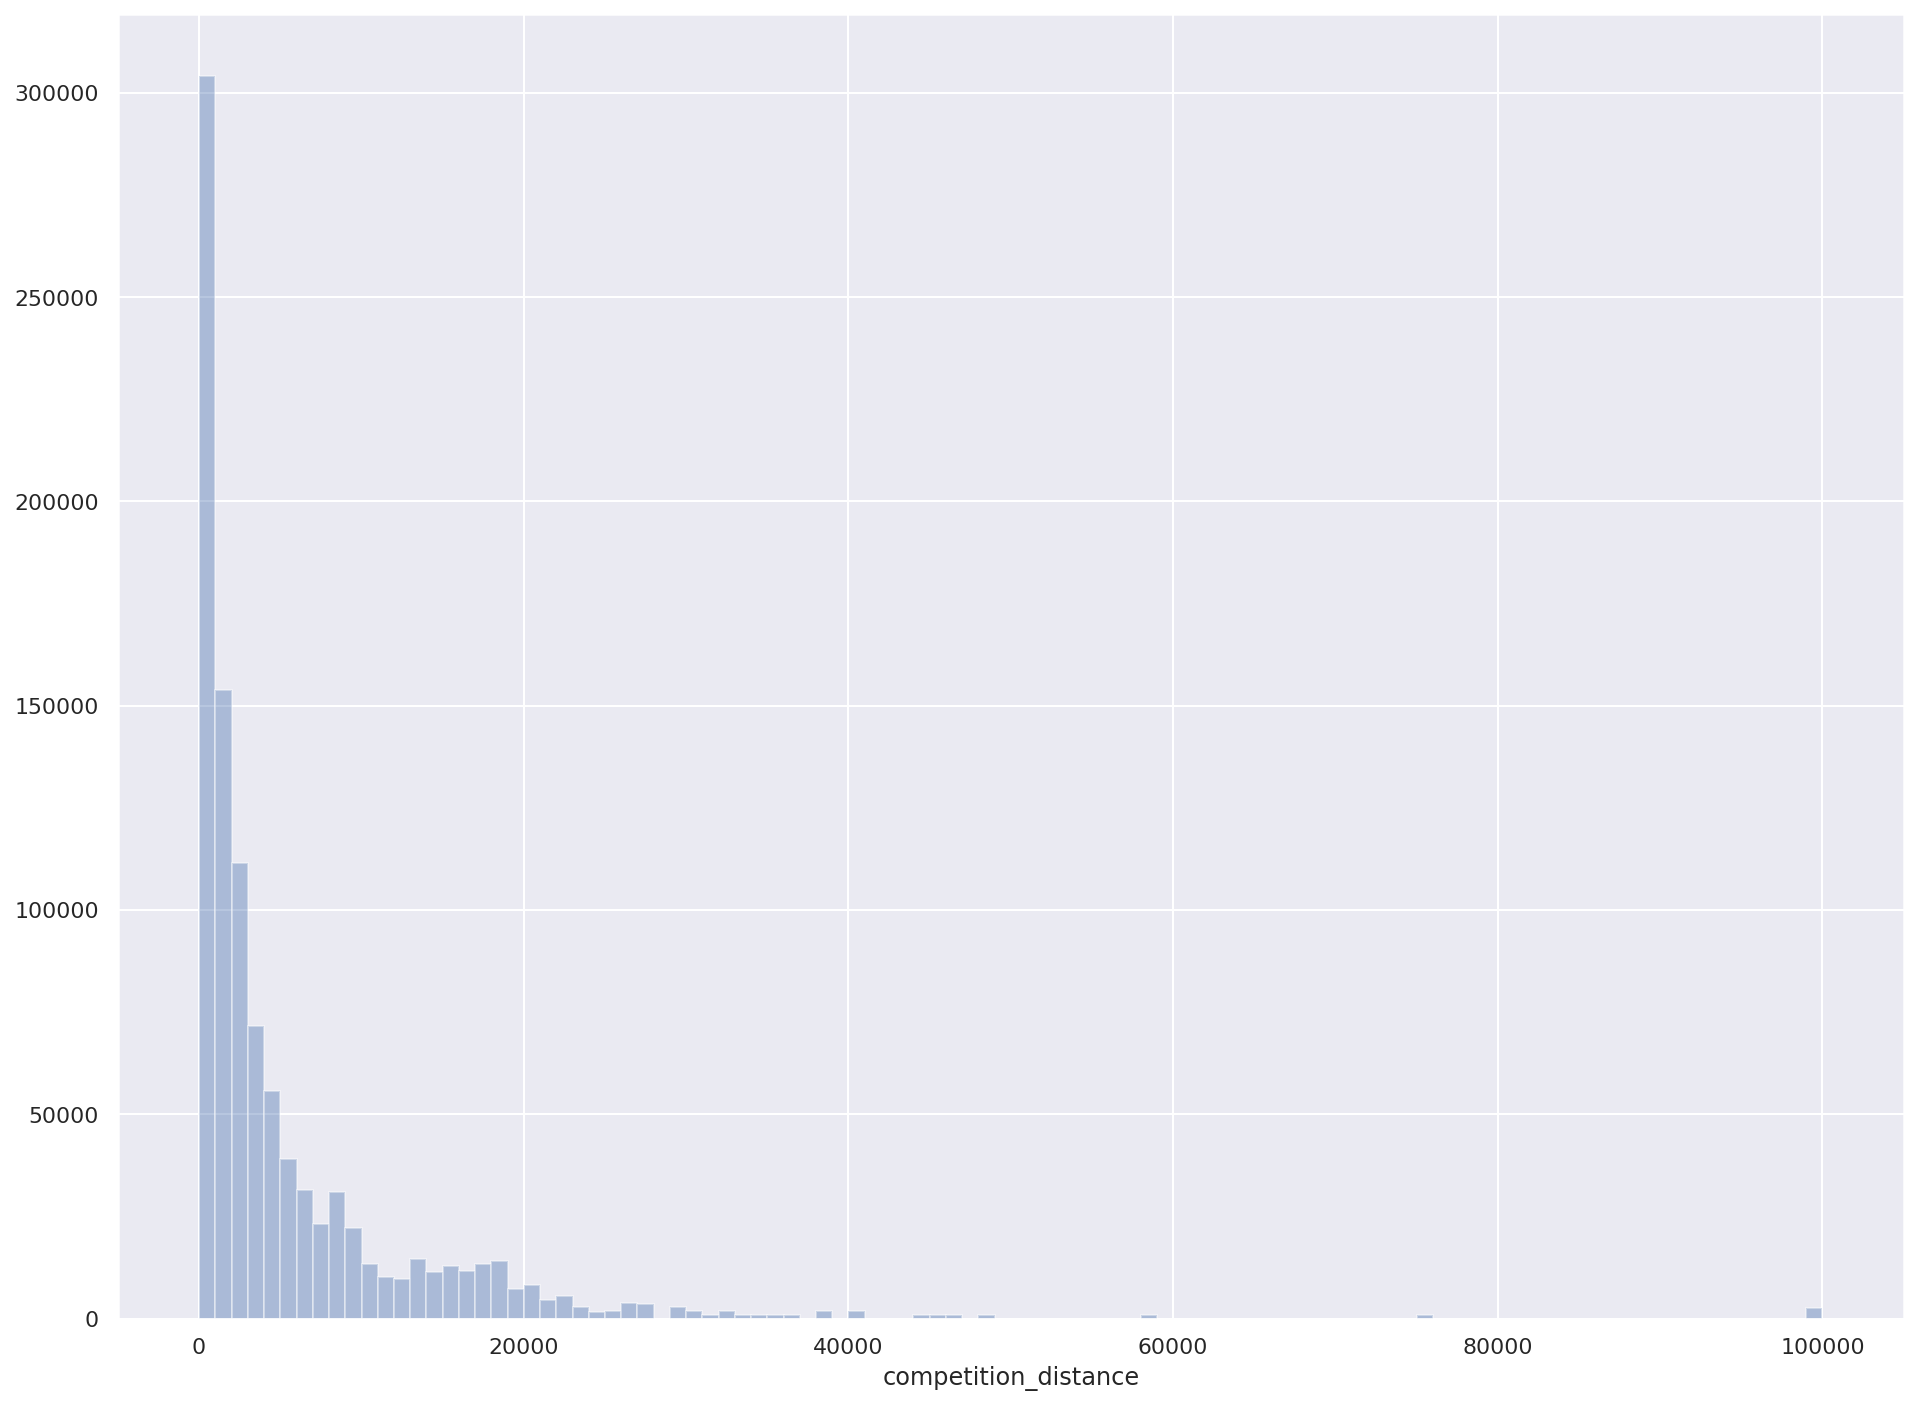

In [79]:
sns.distplot( df1['competition_distance'], kde=False, bins=100);

### Categorical Atributes

In [74]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

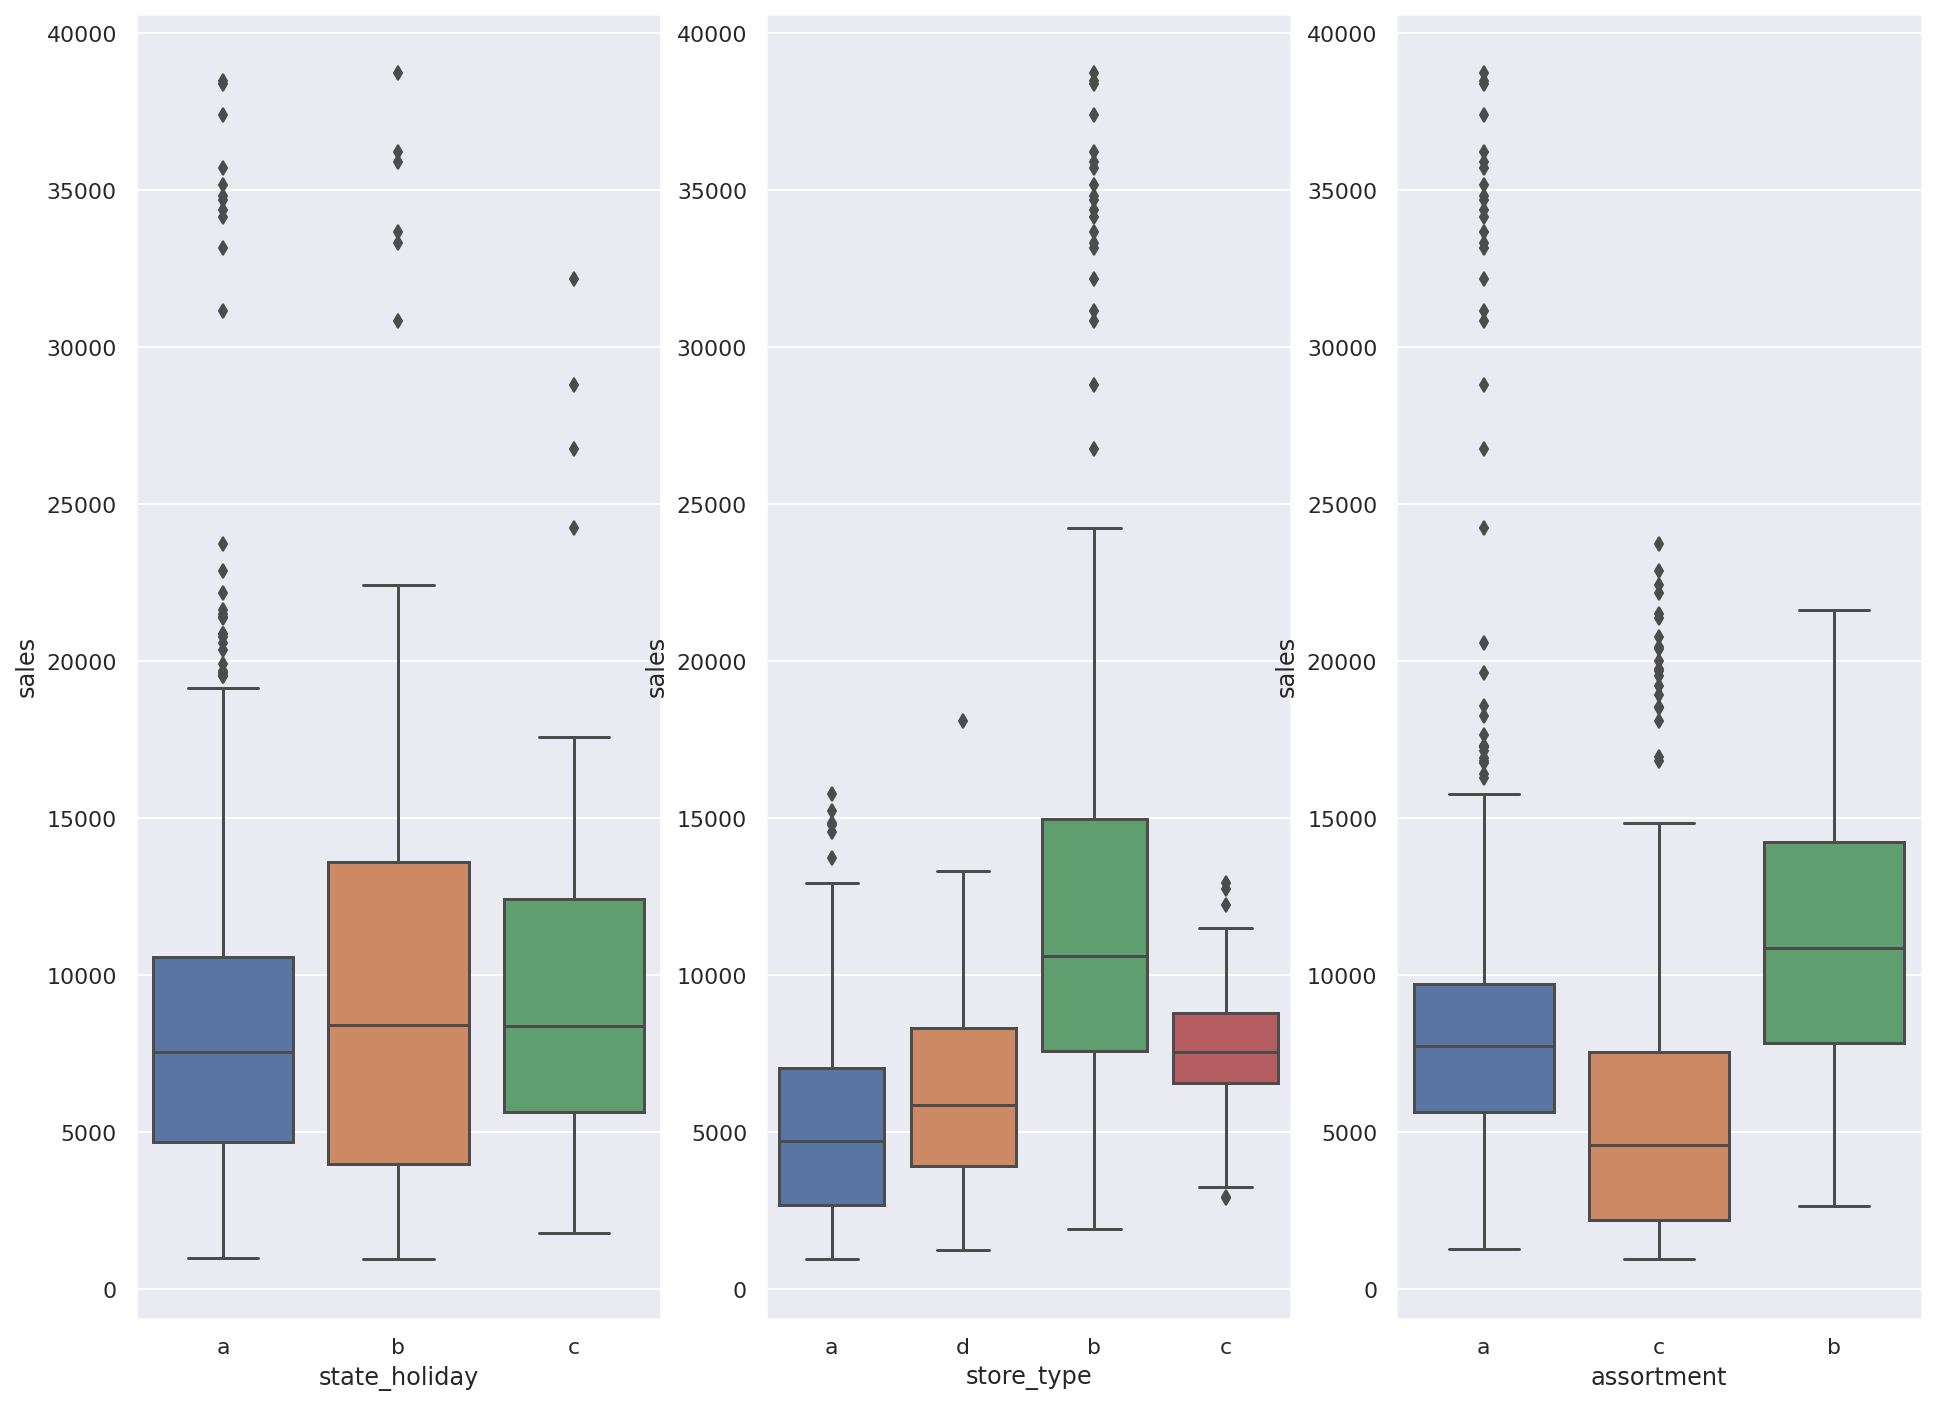

In [80]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux );

In [81]:
save_data ( df1, 'df1.pkl')

# FEATURE ENGINEERING

In [82]:
df2 = load_data ( 'df1.pkl' )

## Mapa Mental de Hipoteses

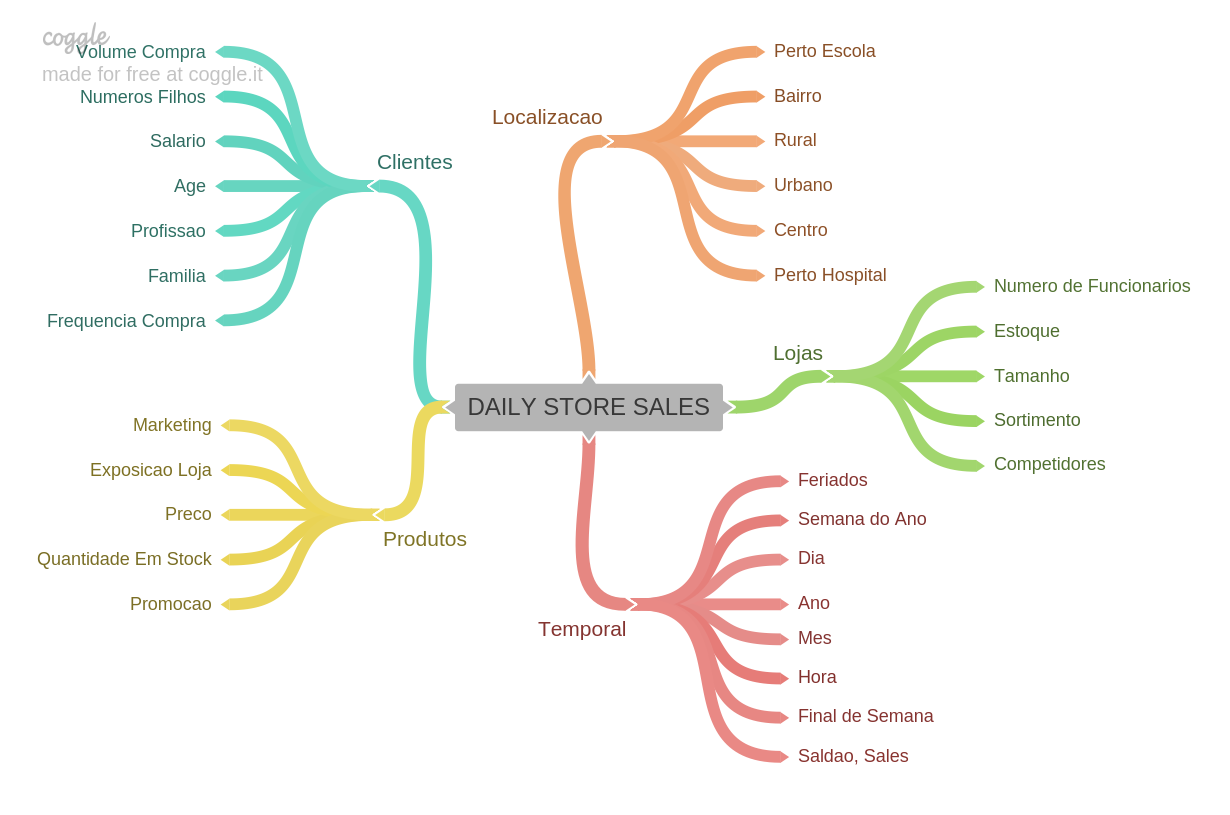

In [84]:
Image( '../images/MindMapHypothesis.png' )

## Criacao das Hipoteses

### Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## Feature Engineering

In [85]:
# year
df2['year'] = df2['date'].dt.year

In [86]:
# month
df2['month'] = df2['date'].dt.month

In [87]:
# day
df2['day'] = df2['date'].dt.day

In [88]:
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

In [89]:
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [90]:
# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

In [91]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

In [92]:
# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

In [93]:
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [94]:
save_data ( df2, 'df2.pkl' )

# FILTRAGEM DE VARIÁVEIS

In [96]:
df3 = load_data ( 'df2.pkl' )

## Filtragem das Linhas

In [97]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Selecao das Colunas

In [98]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [99]:
save_data( df3, 'df3.pkl' )

# ANALISE EXPLORATORIA DOS DADOS

In [100]:
df4 = load_data( 'df3.pkl' )

## Analise Univariada

### Response Variable

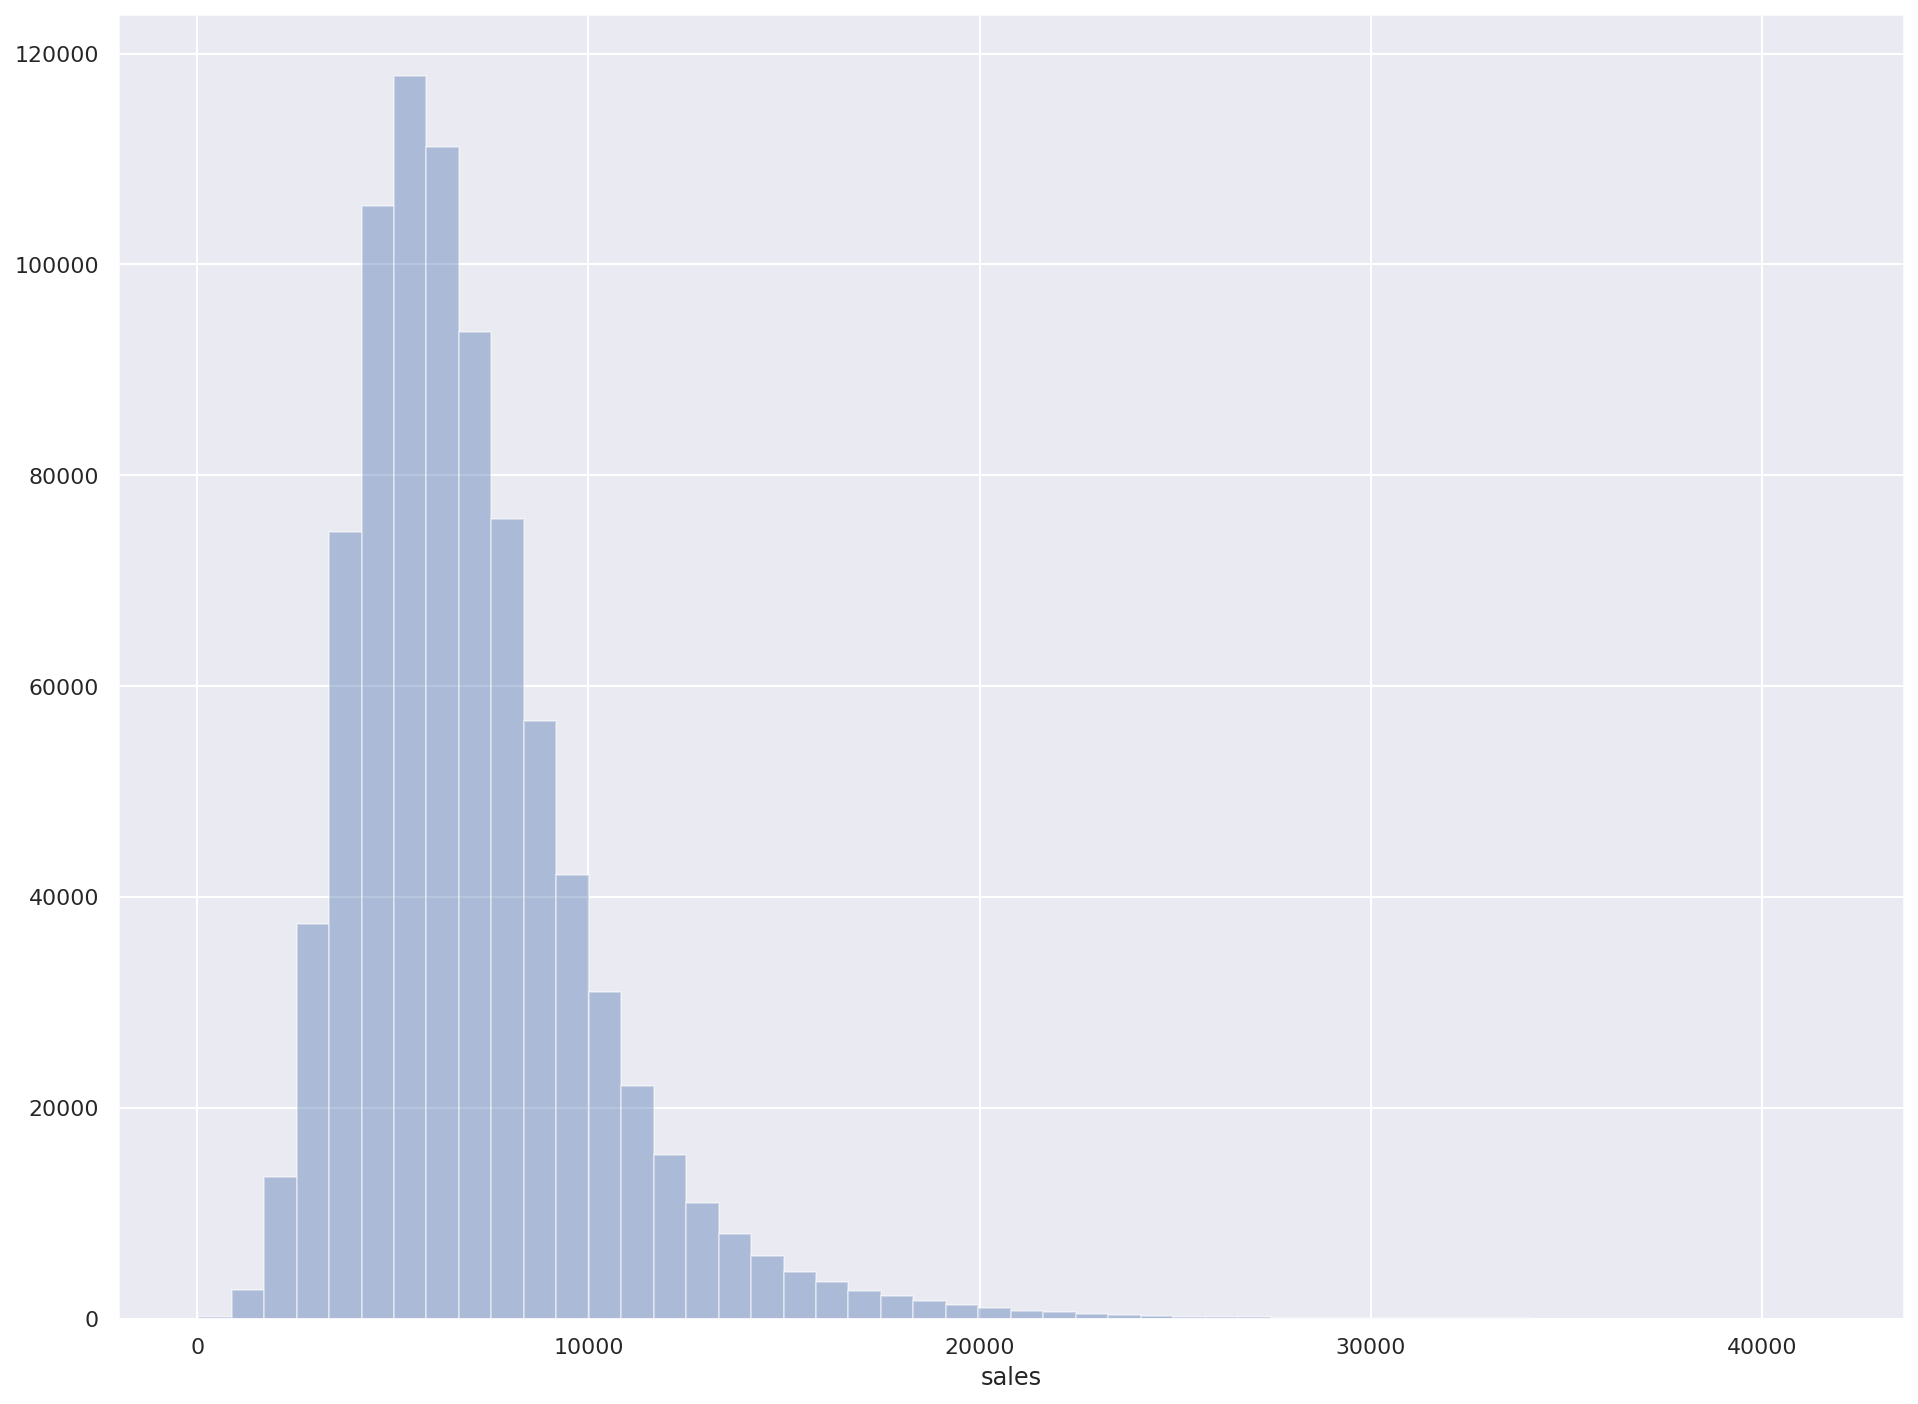

In [101]:
sns.distplot( df4['sales'], kde=False  );

### Numerical Variable

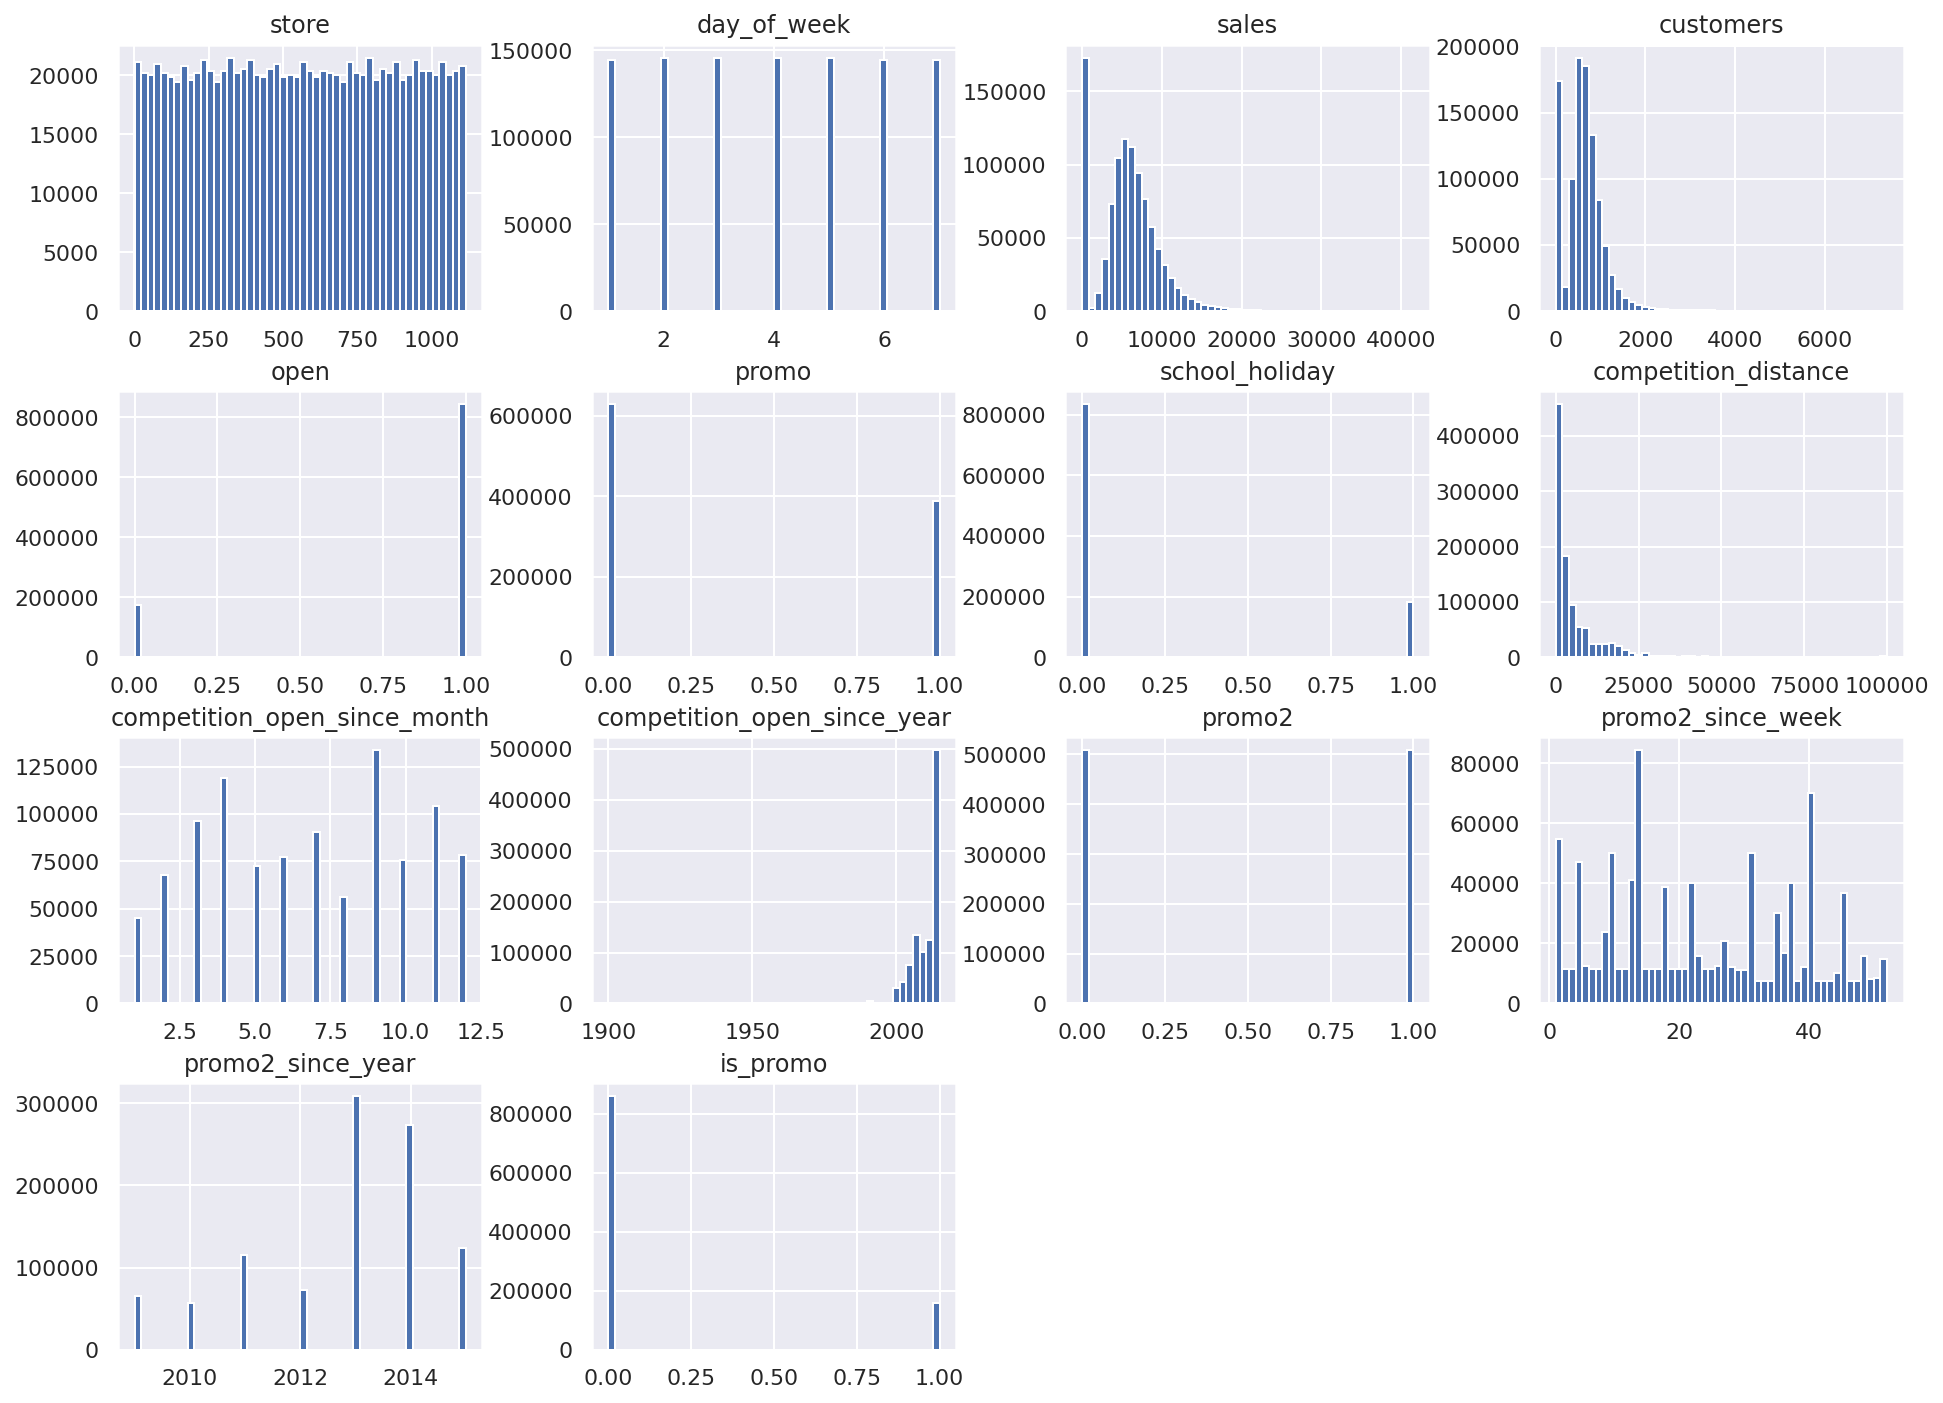

In [103]:
num_attributes.hist( bins=50 );

### Categorical Variable

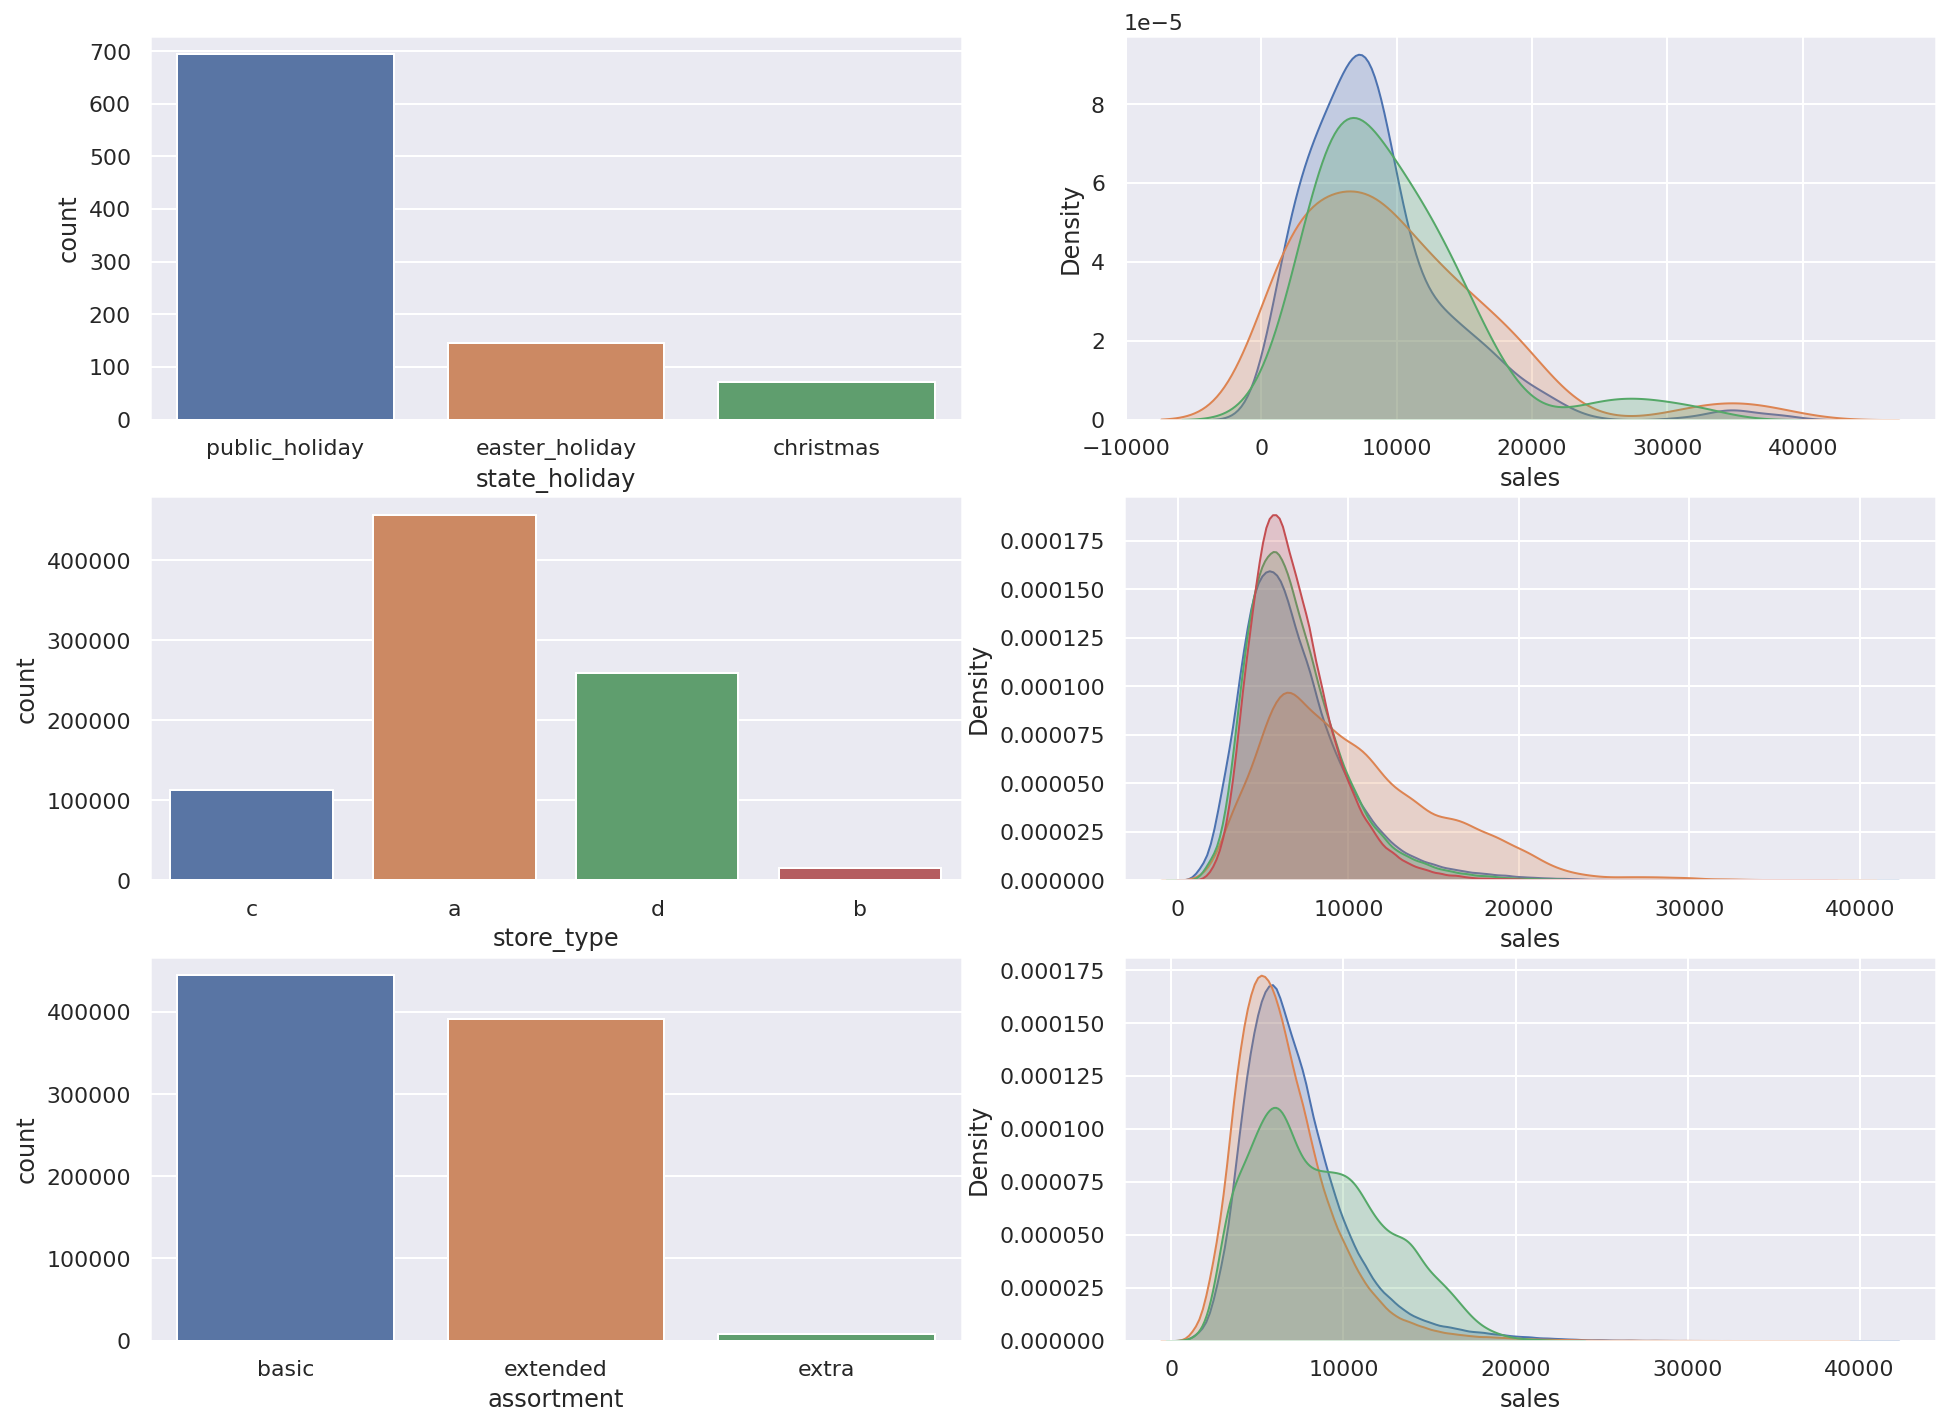

In [104]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True );

## Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

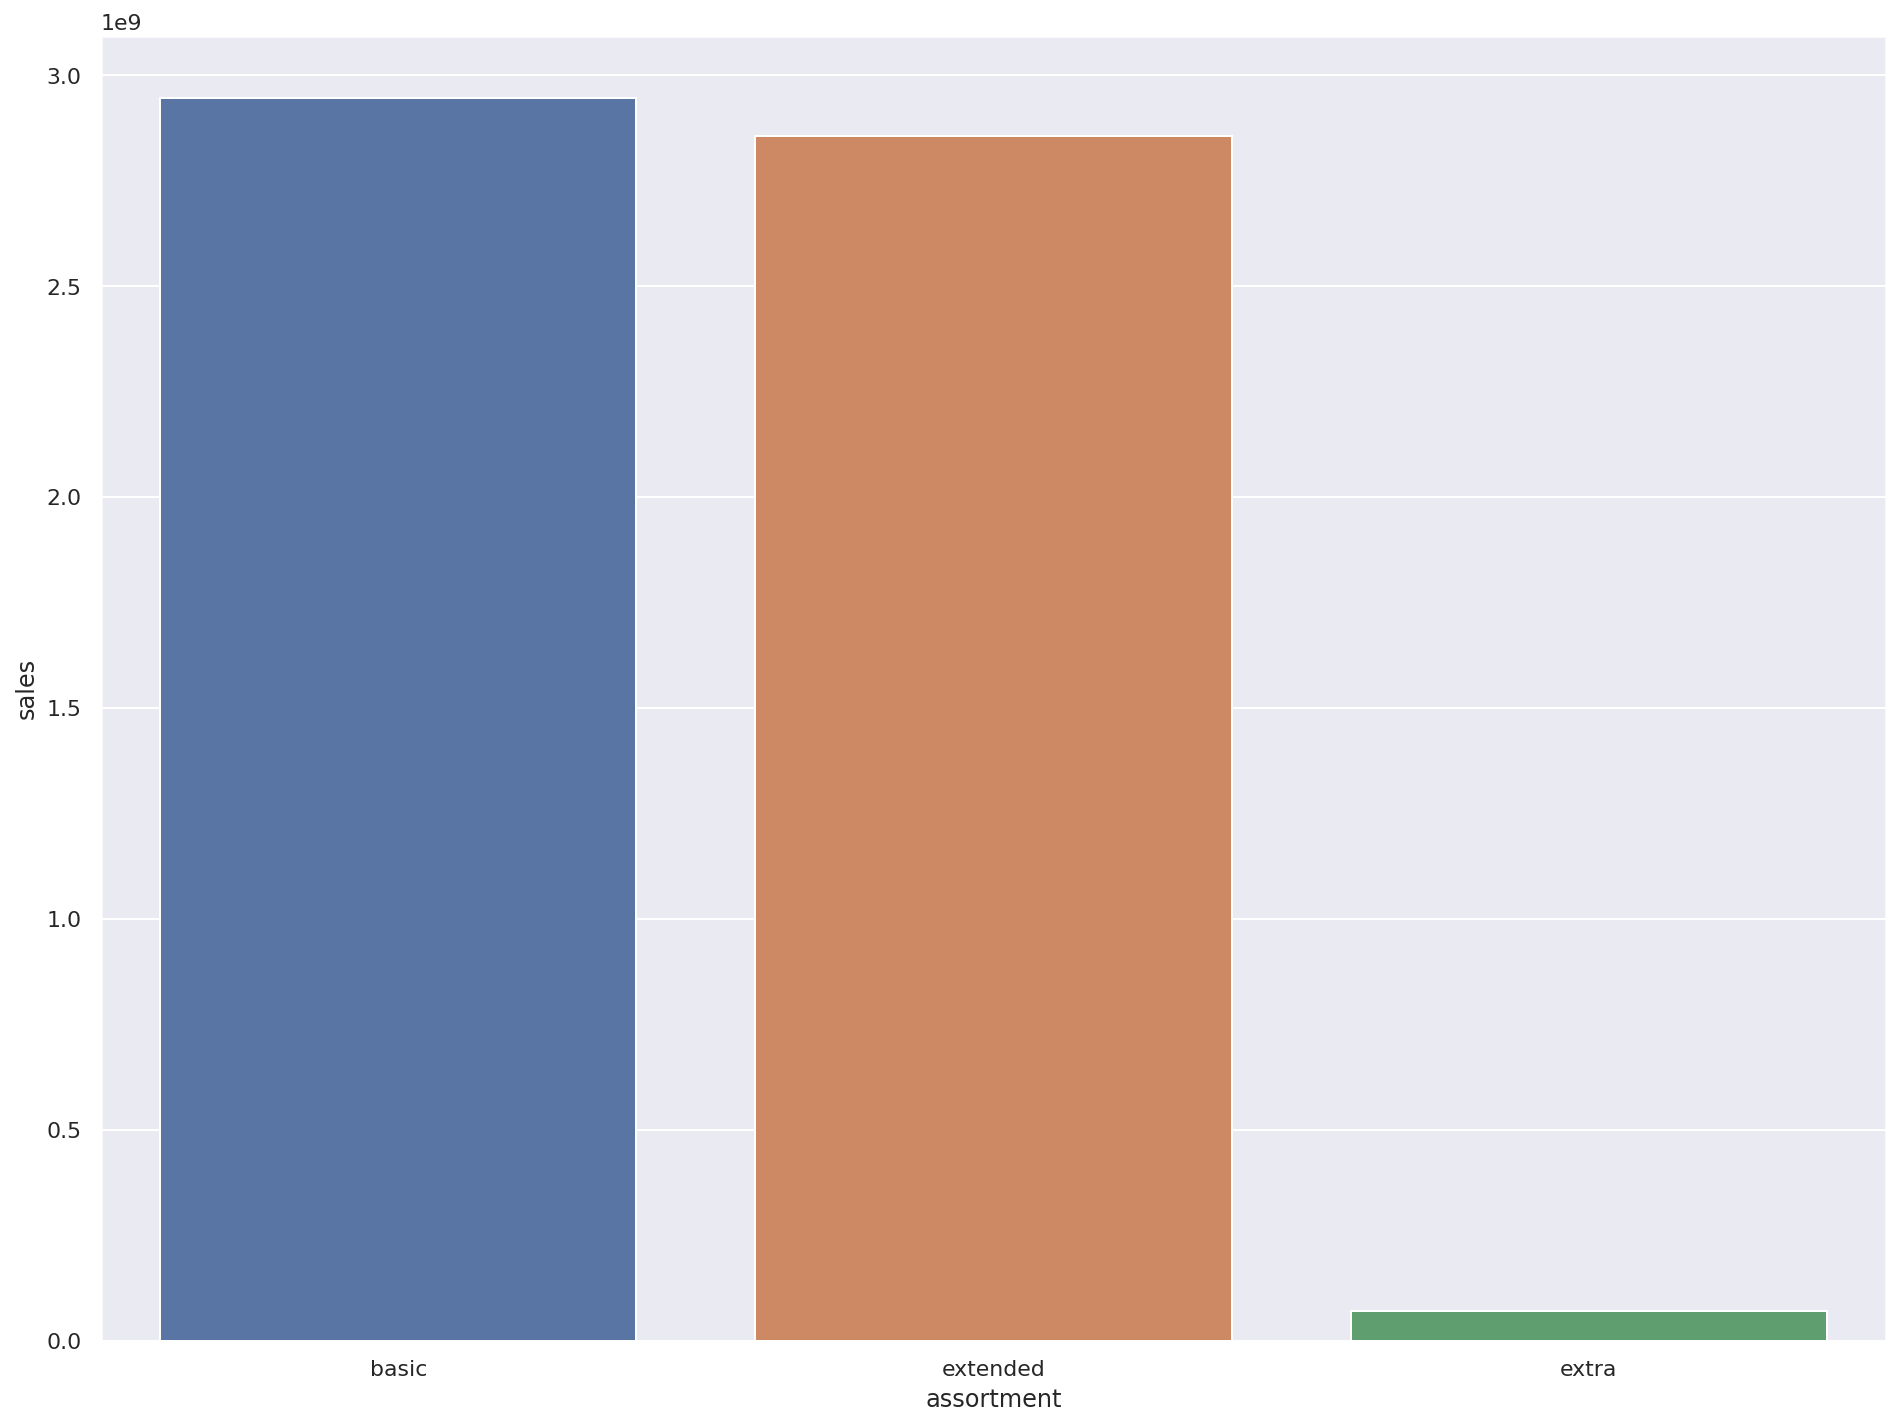

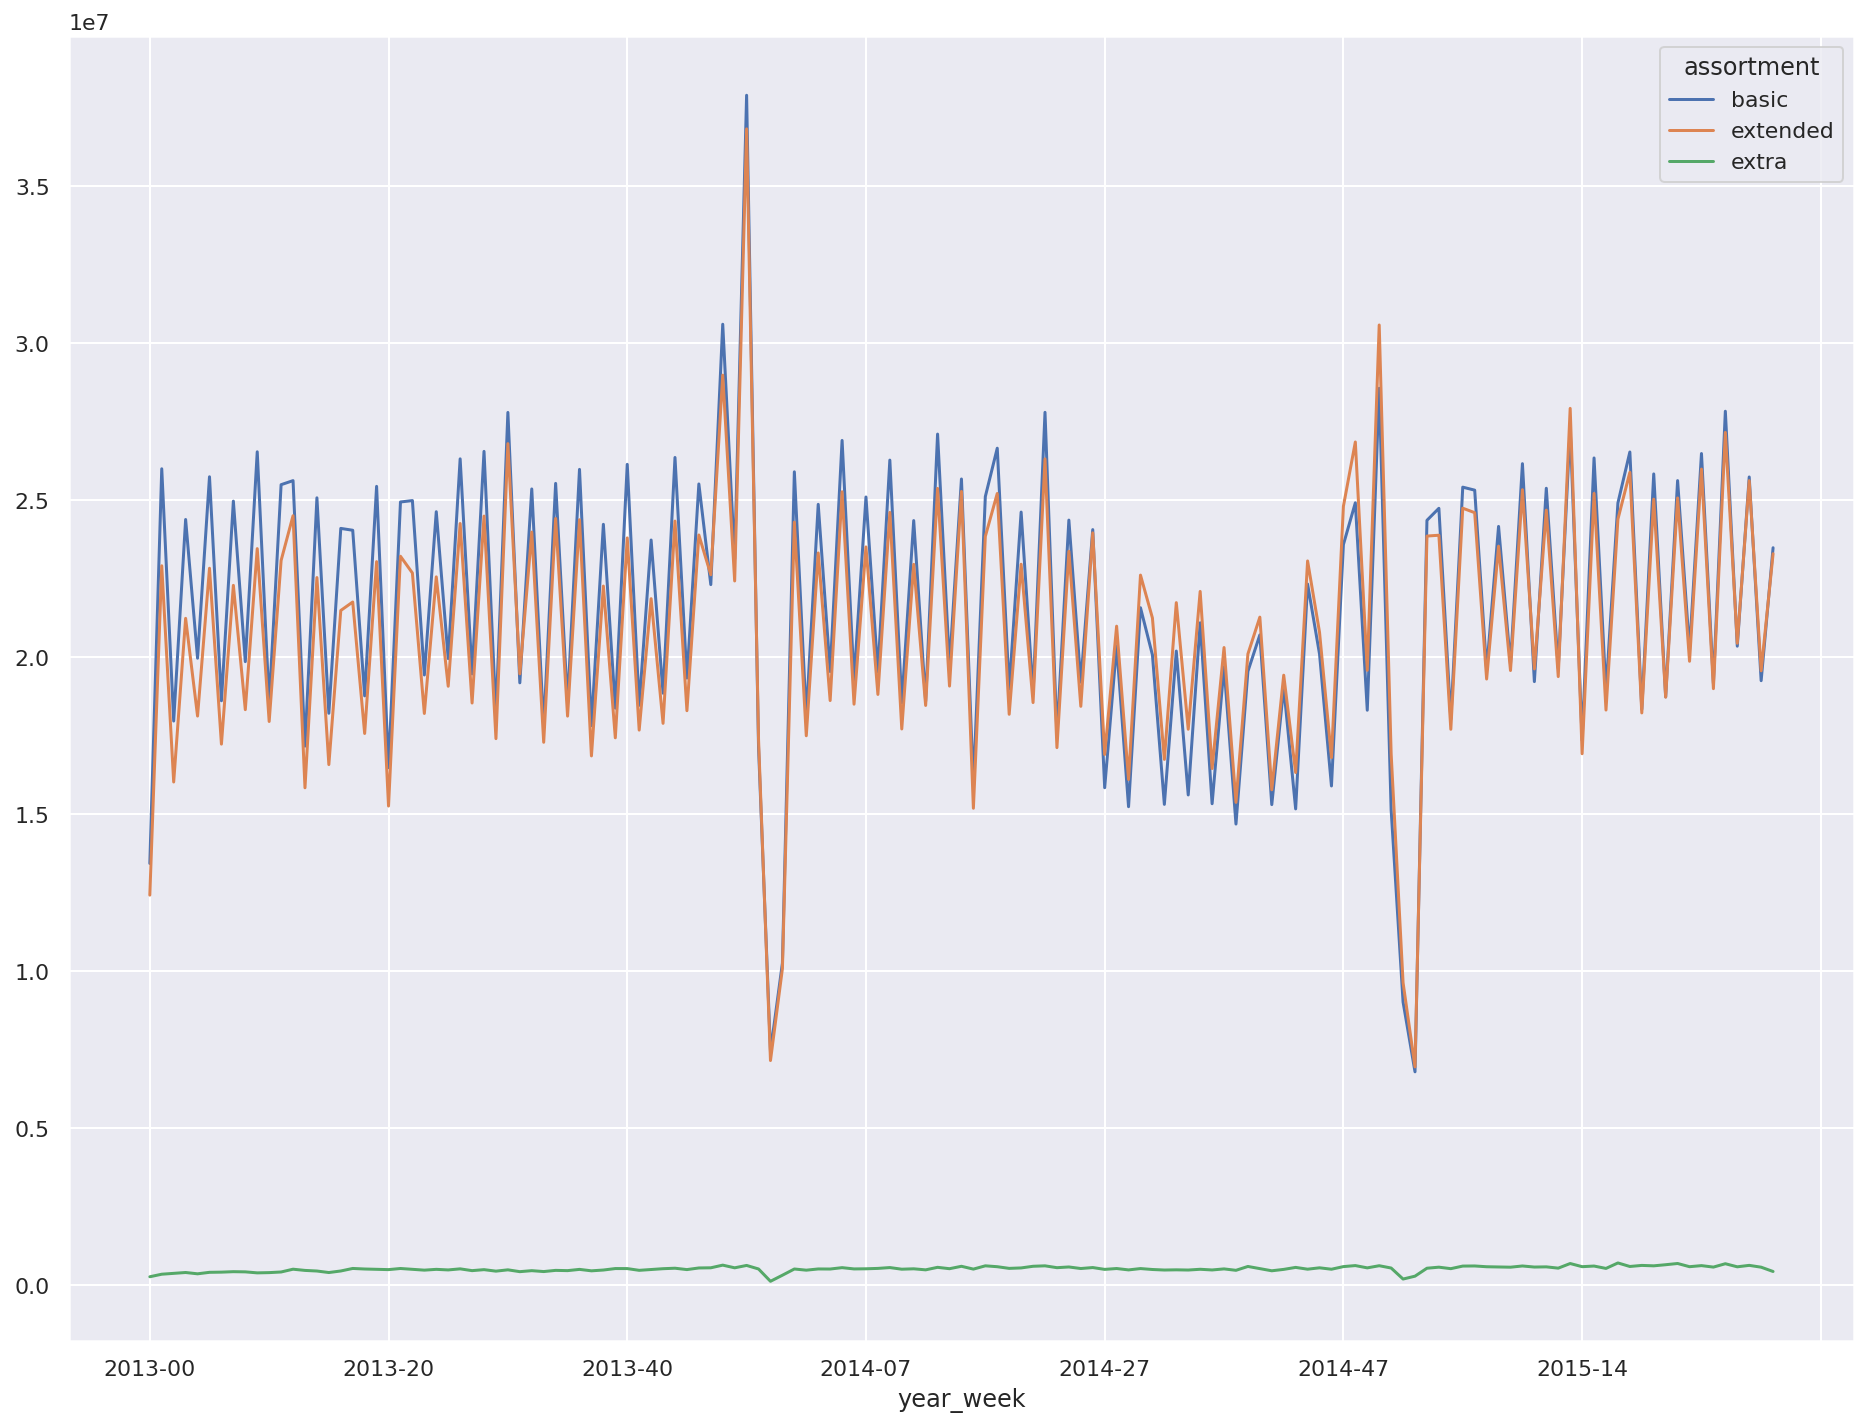

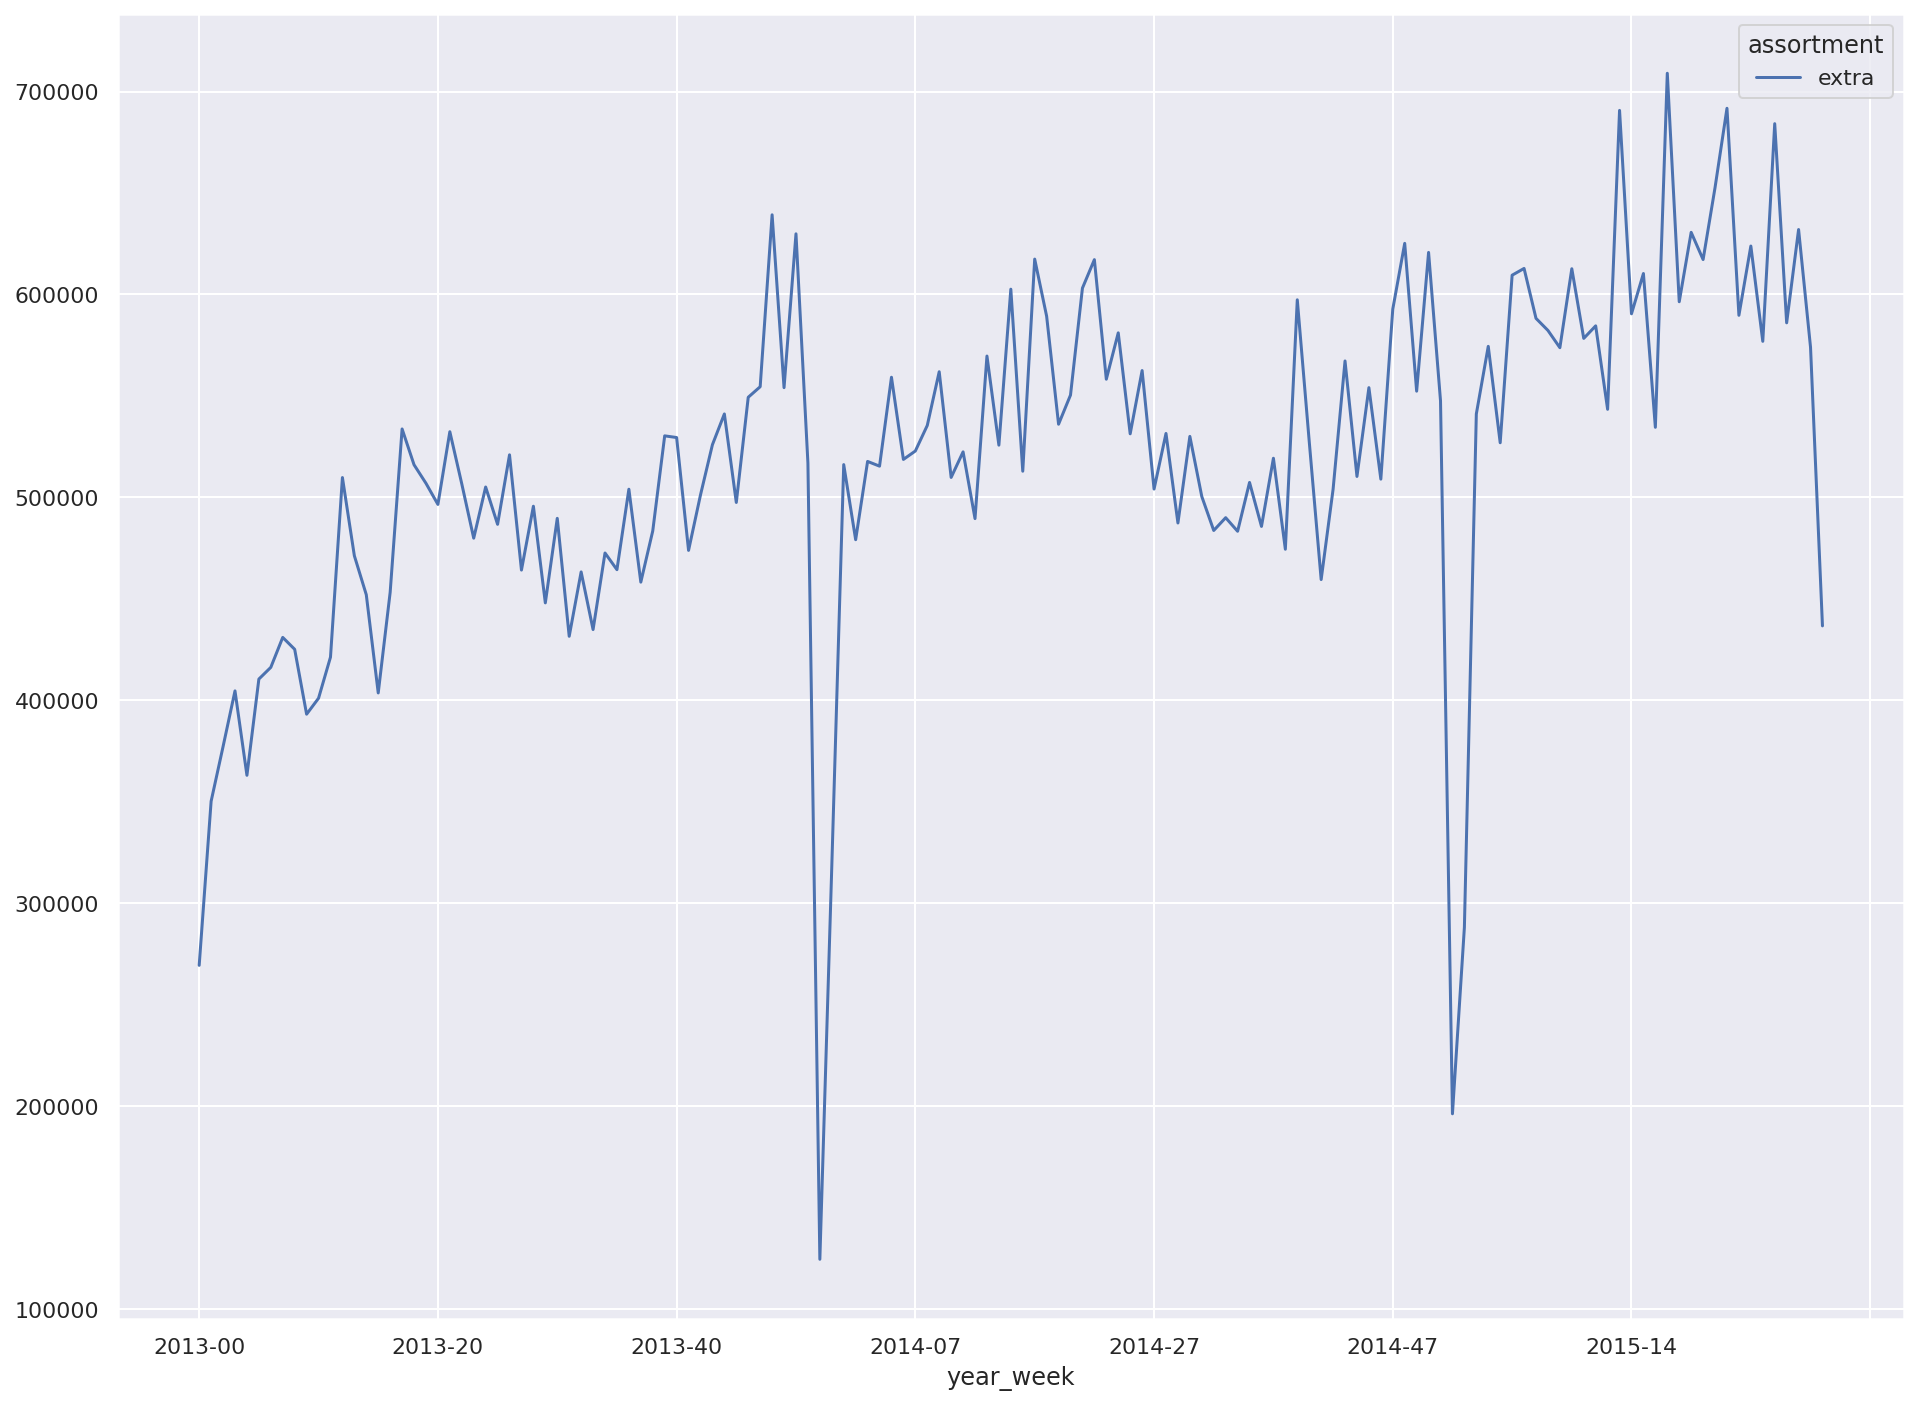

In [105]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

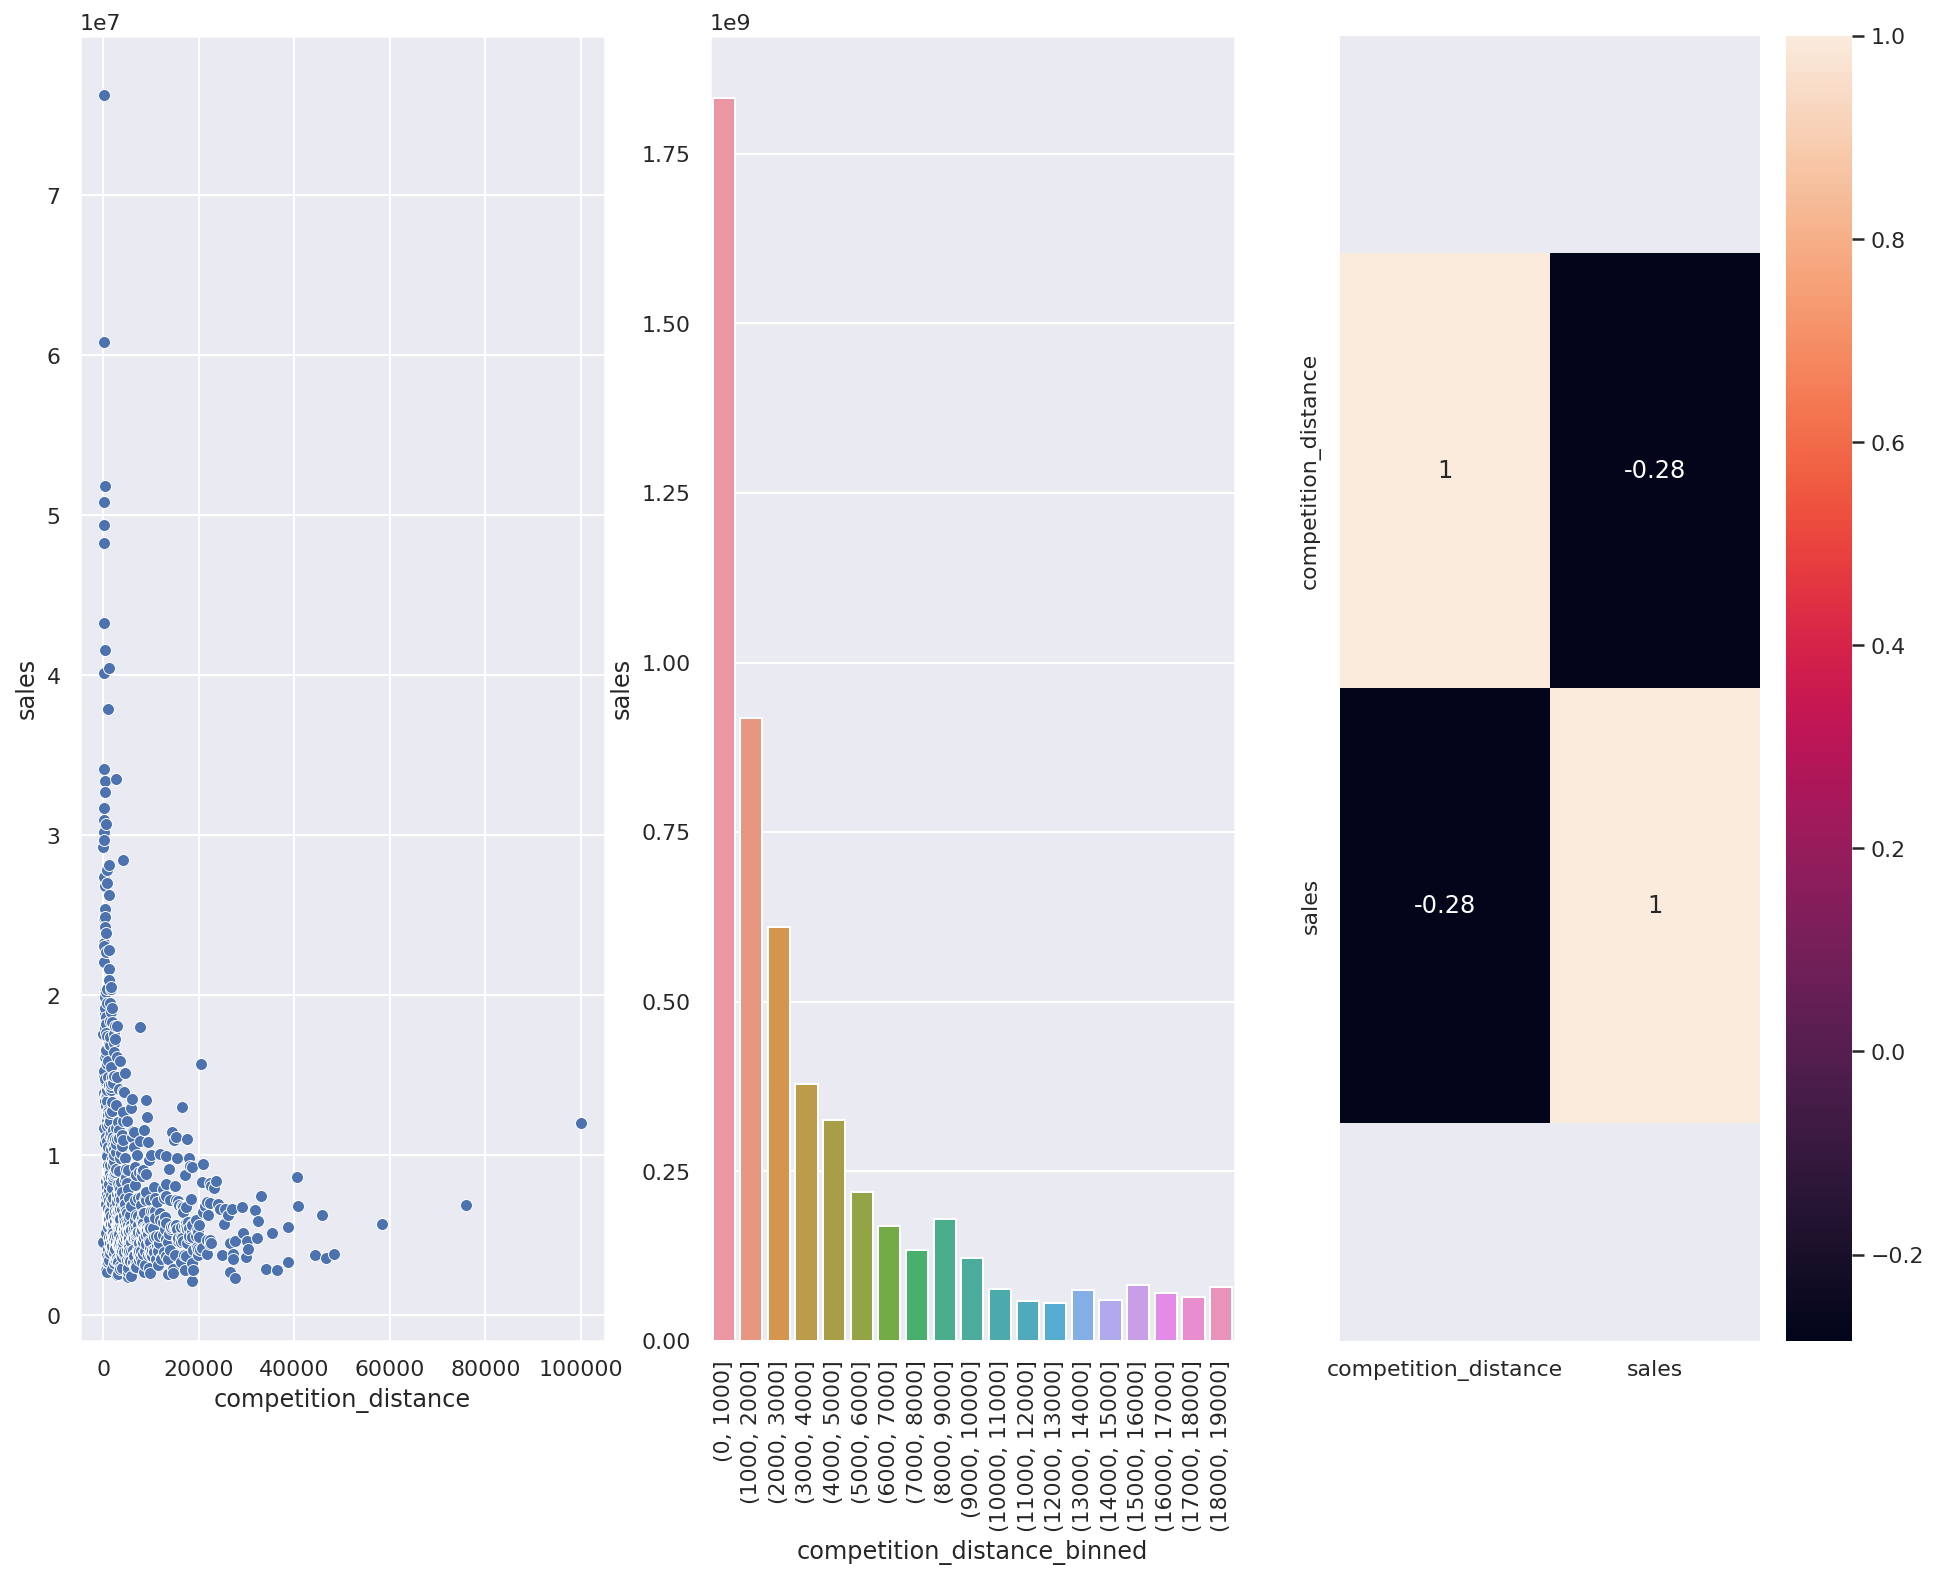

In [106]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

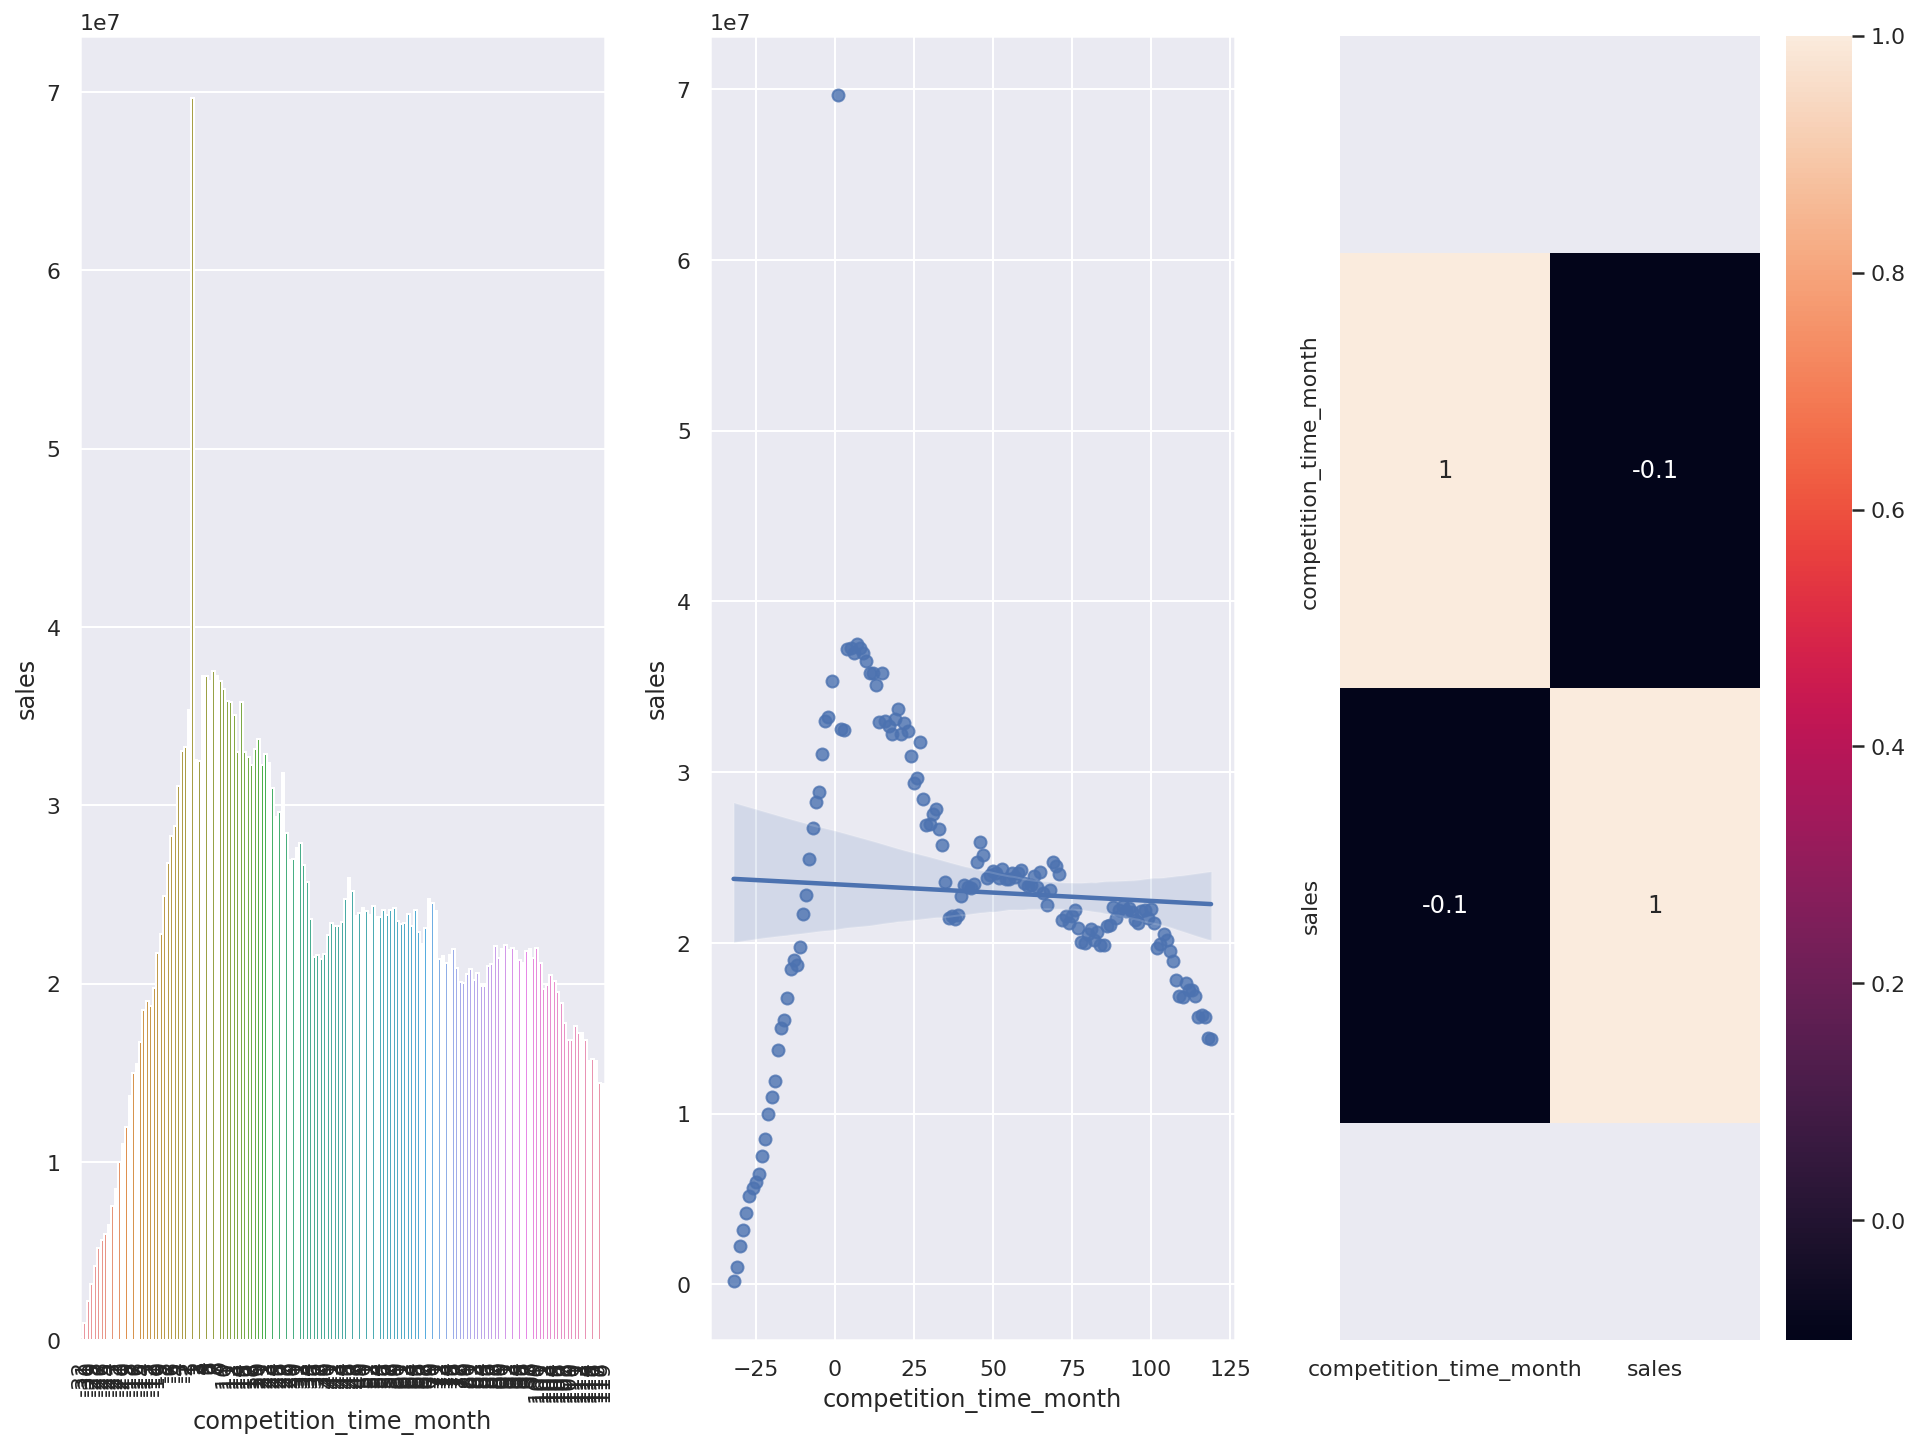

In [107]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

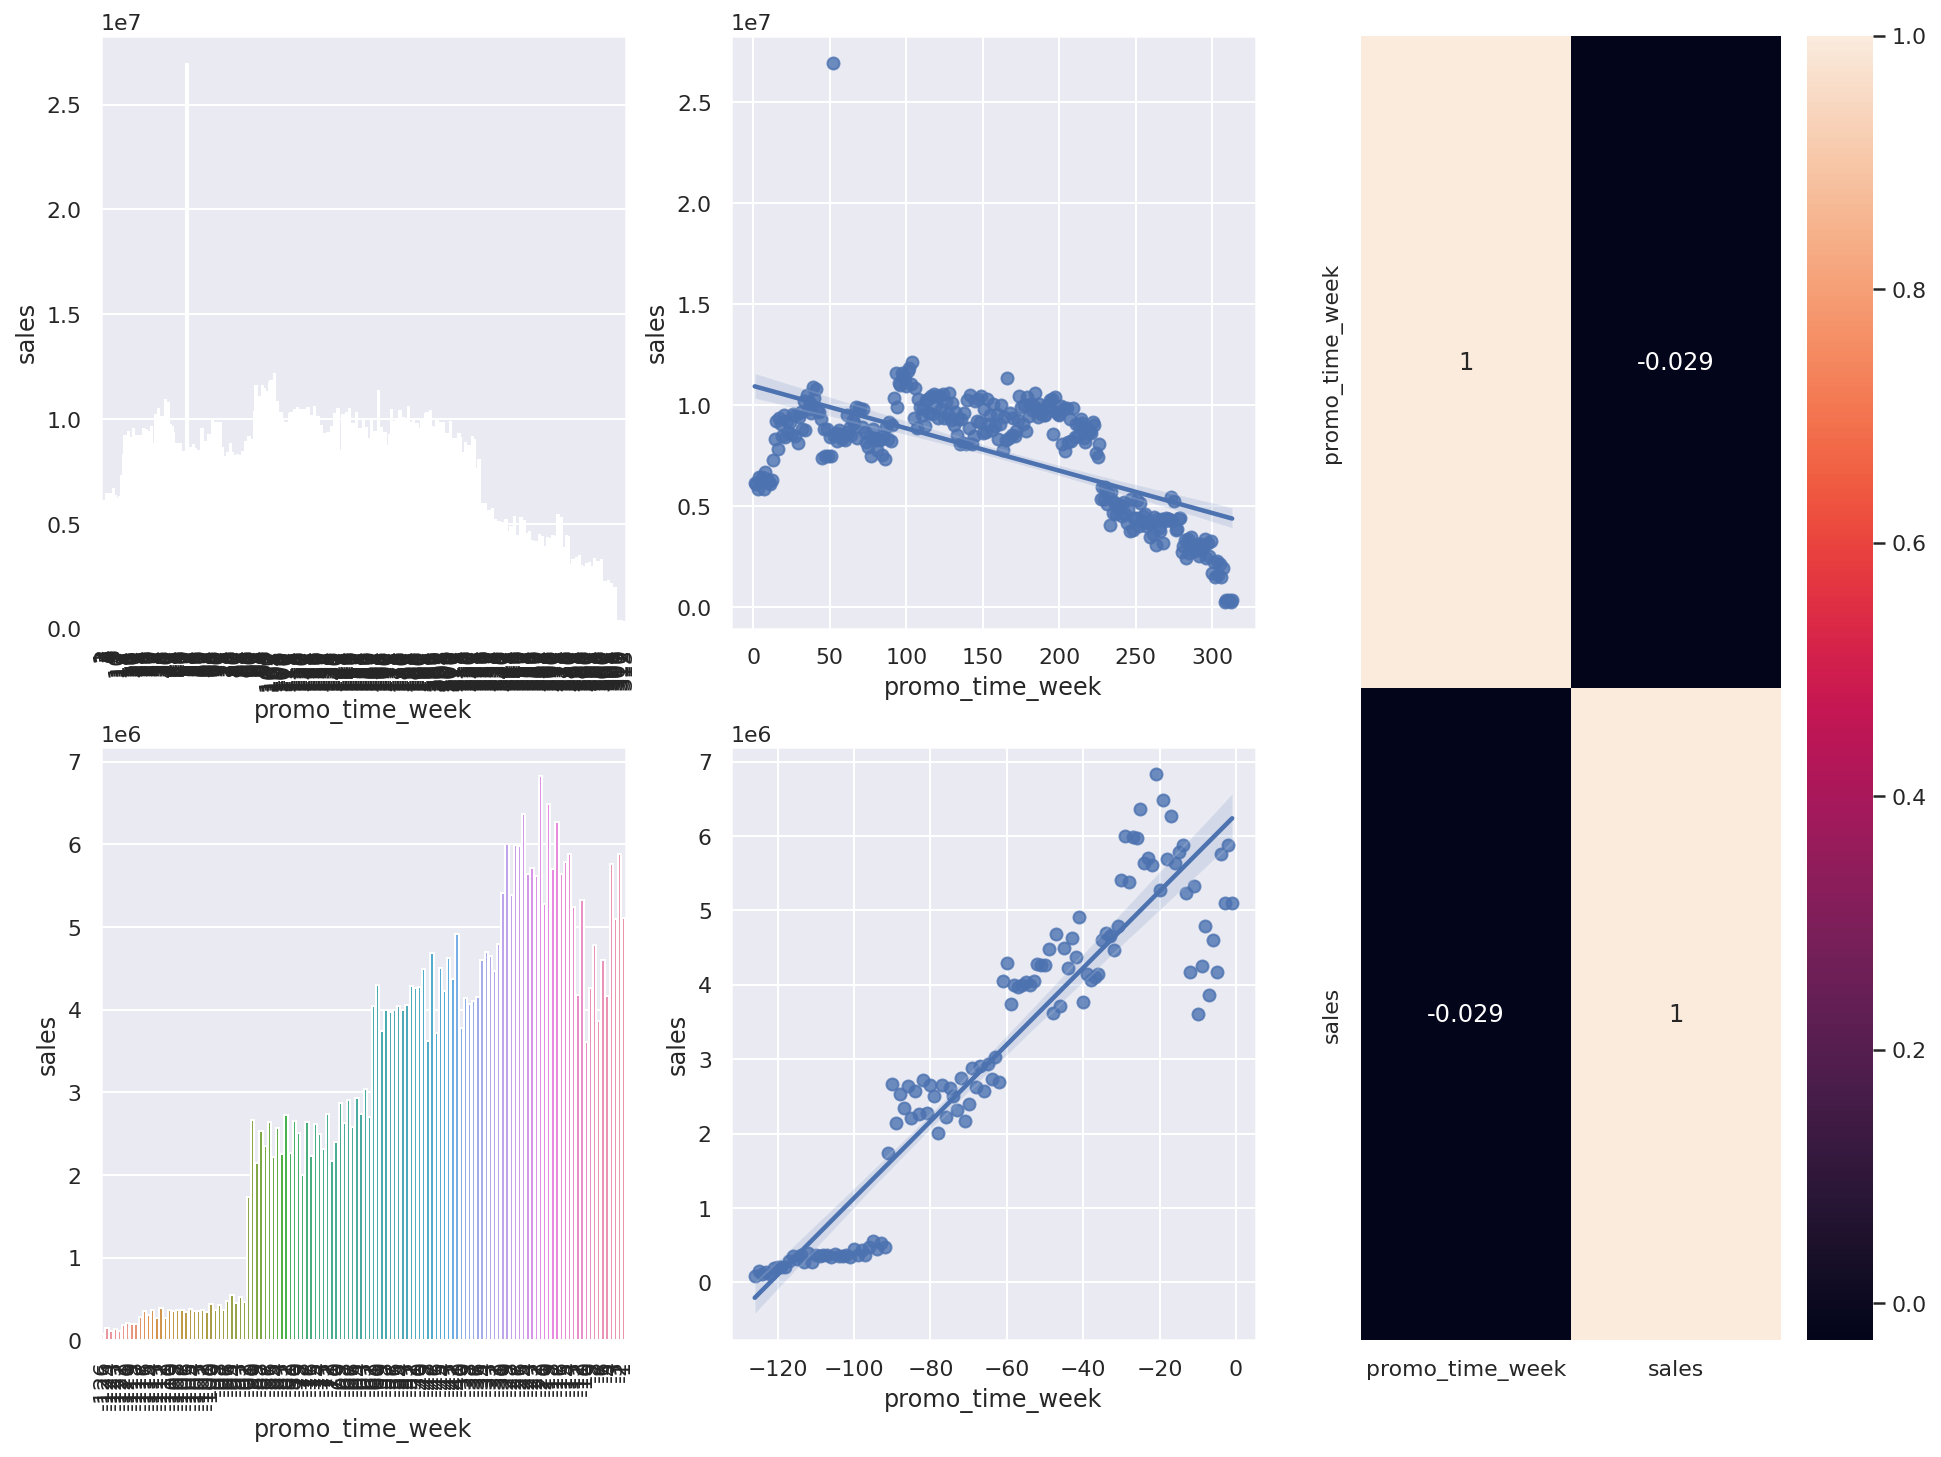

In [108]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [109]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

promo  promo2       sales
0      0       0  1482612096
1      0       1  1289362241
2      1       0  1628930532
3      1       1  1472275754

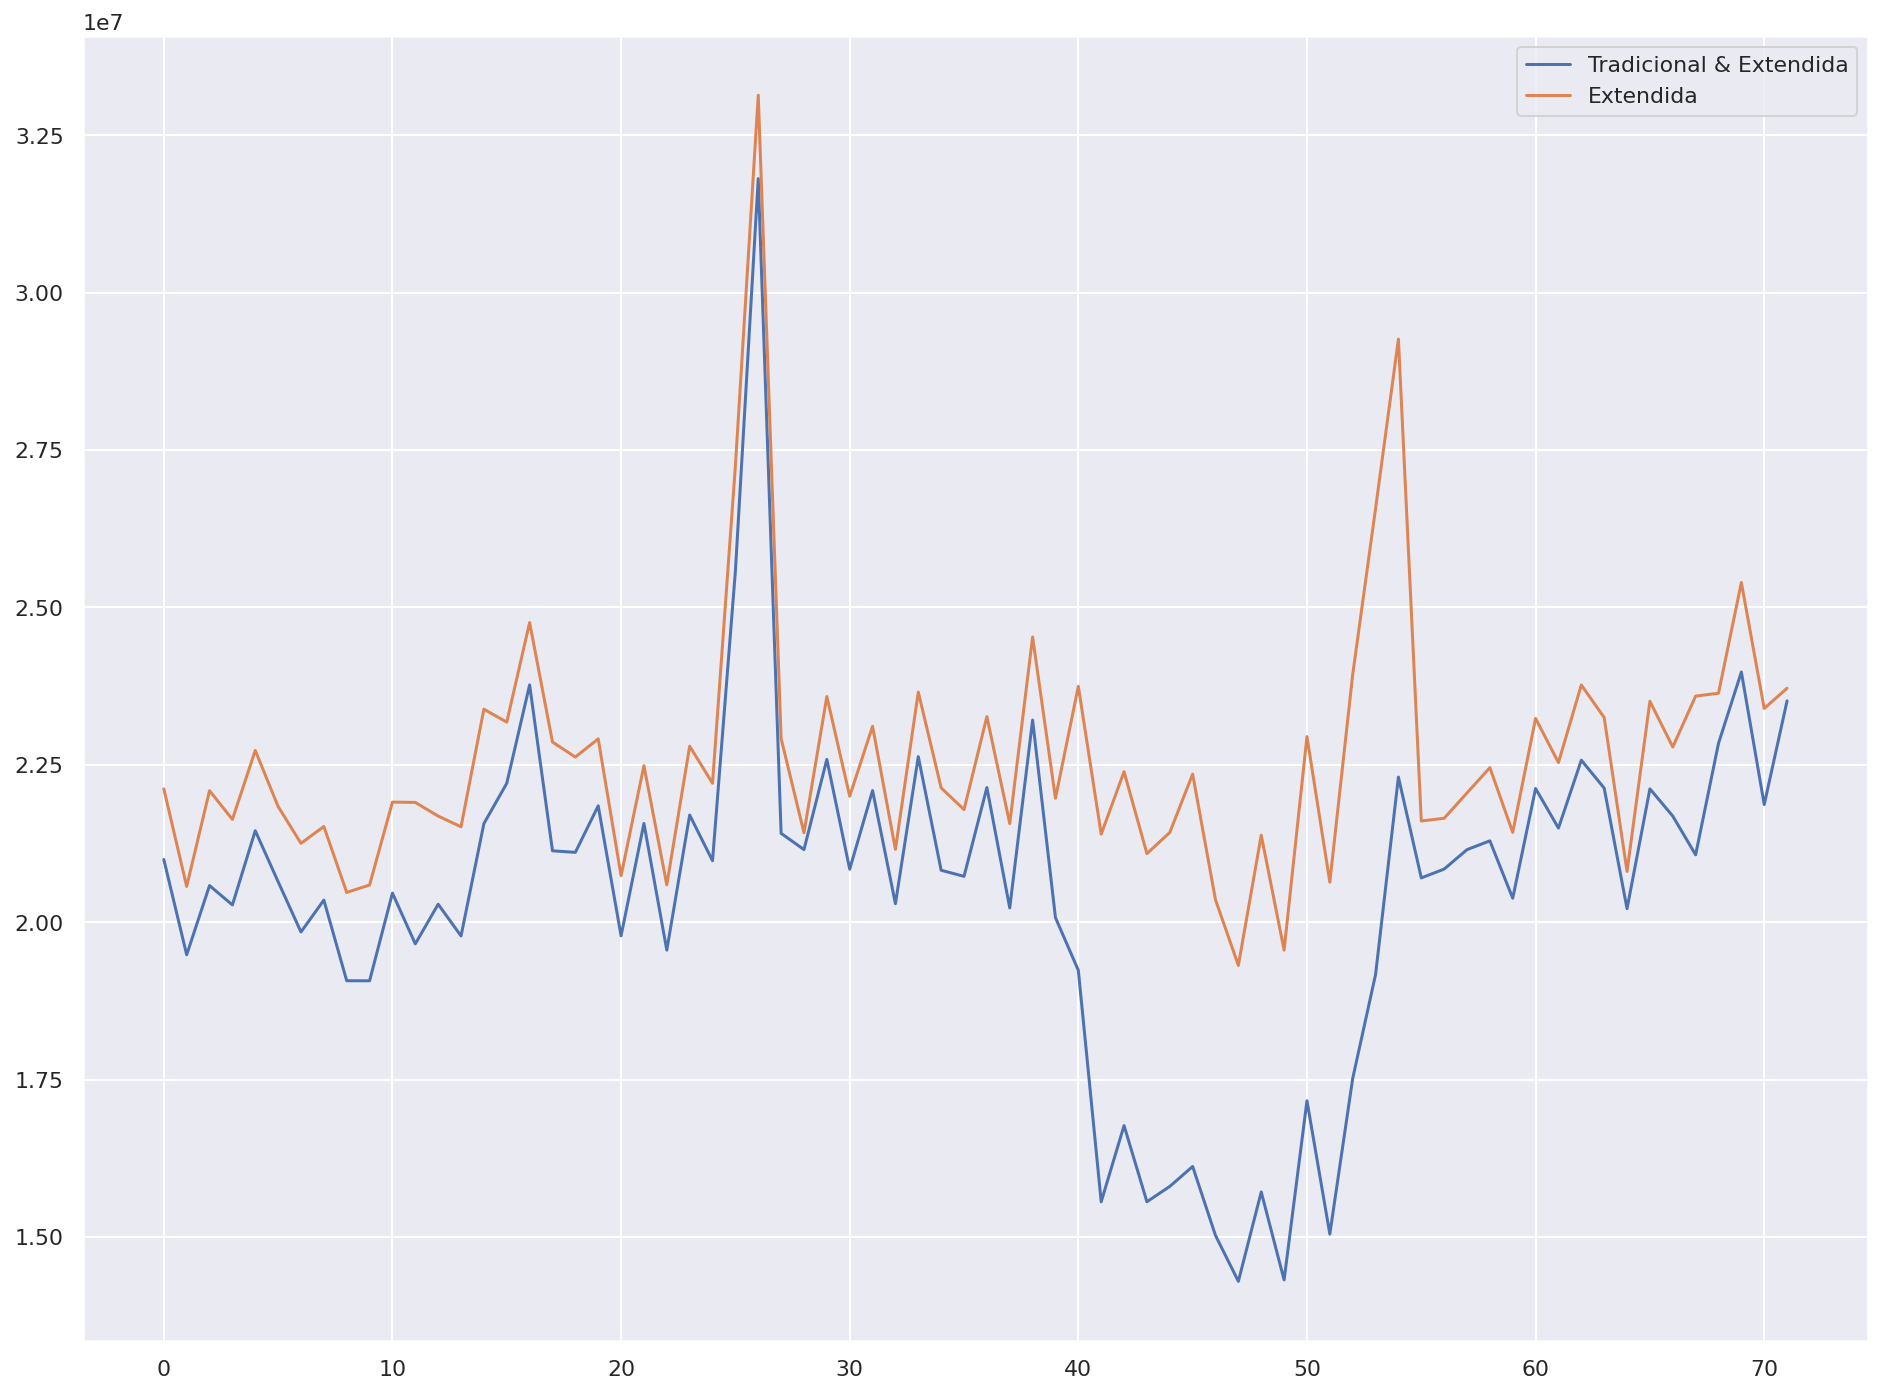

In [110]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

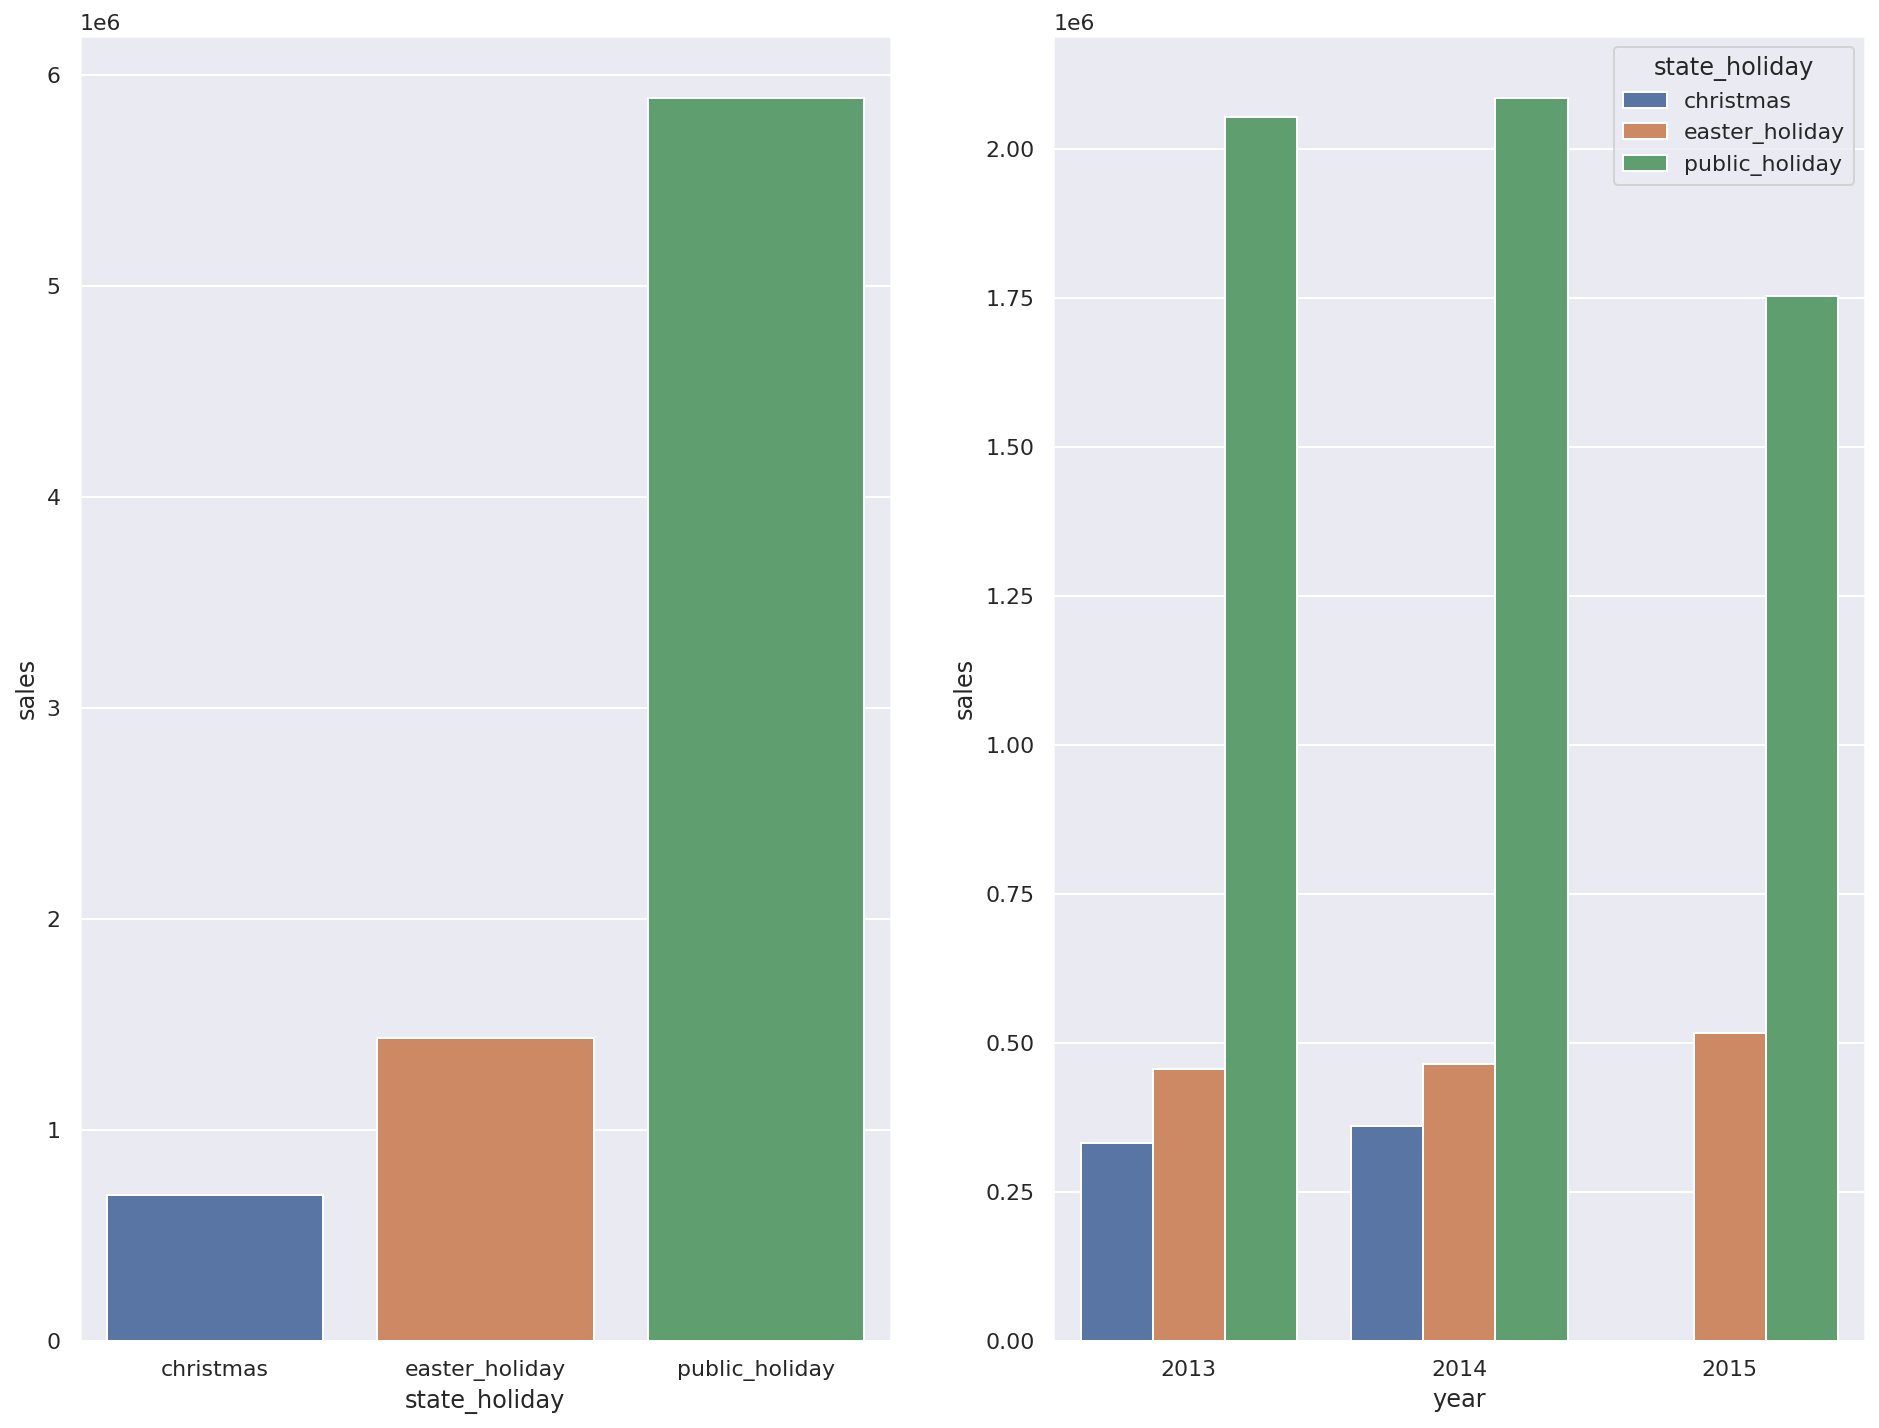

In [111]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H9.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

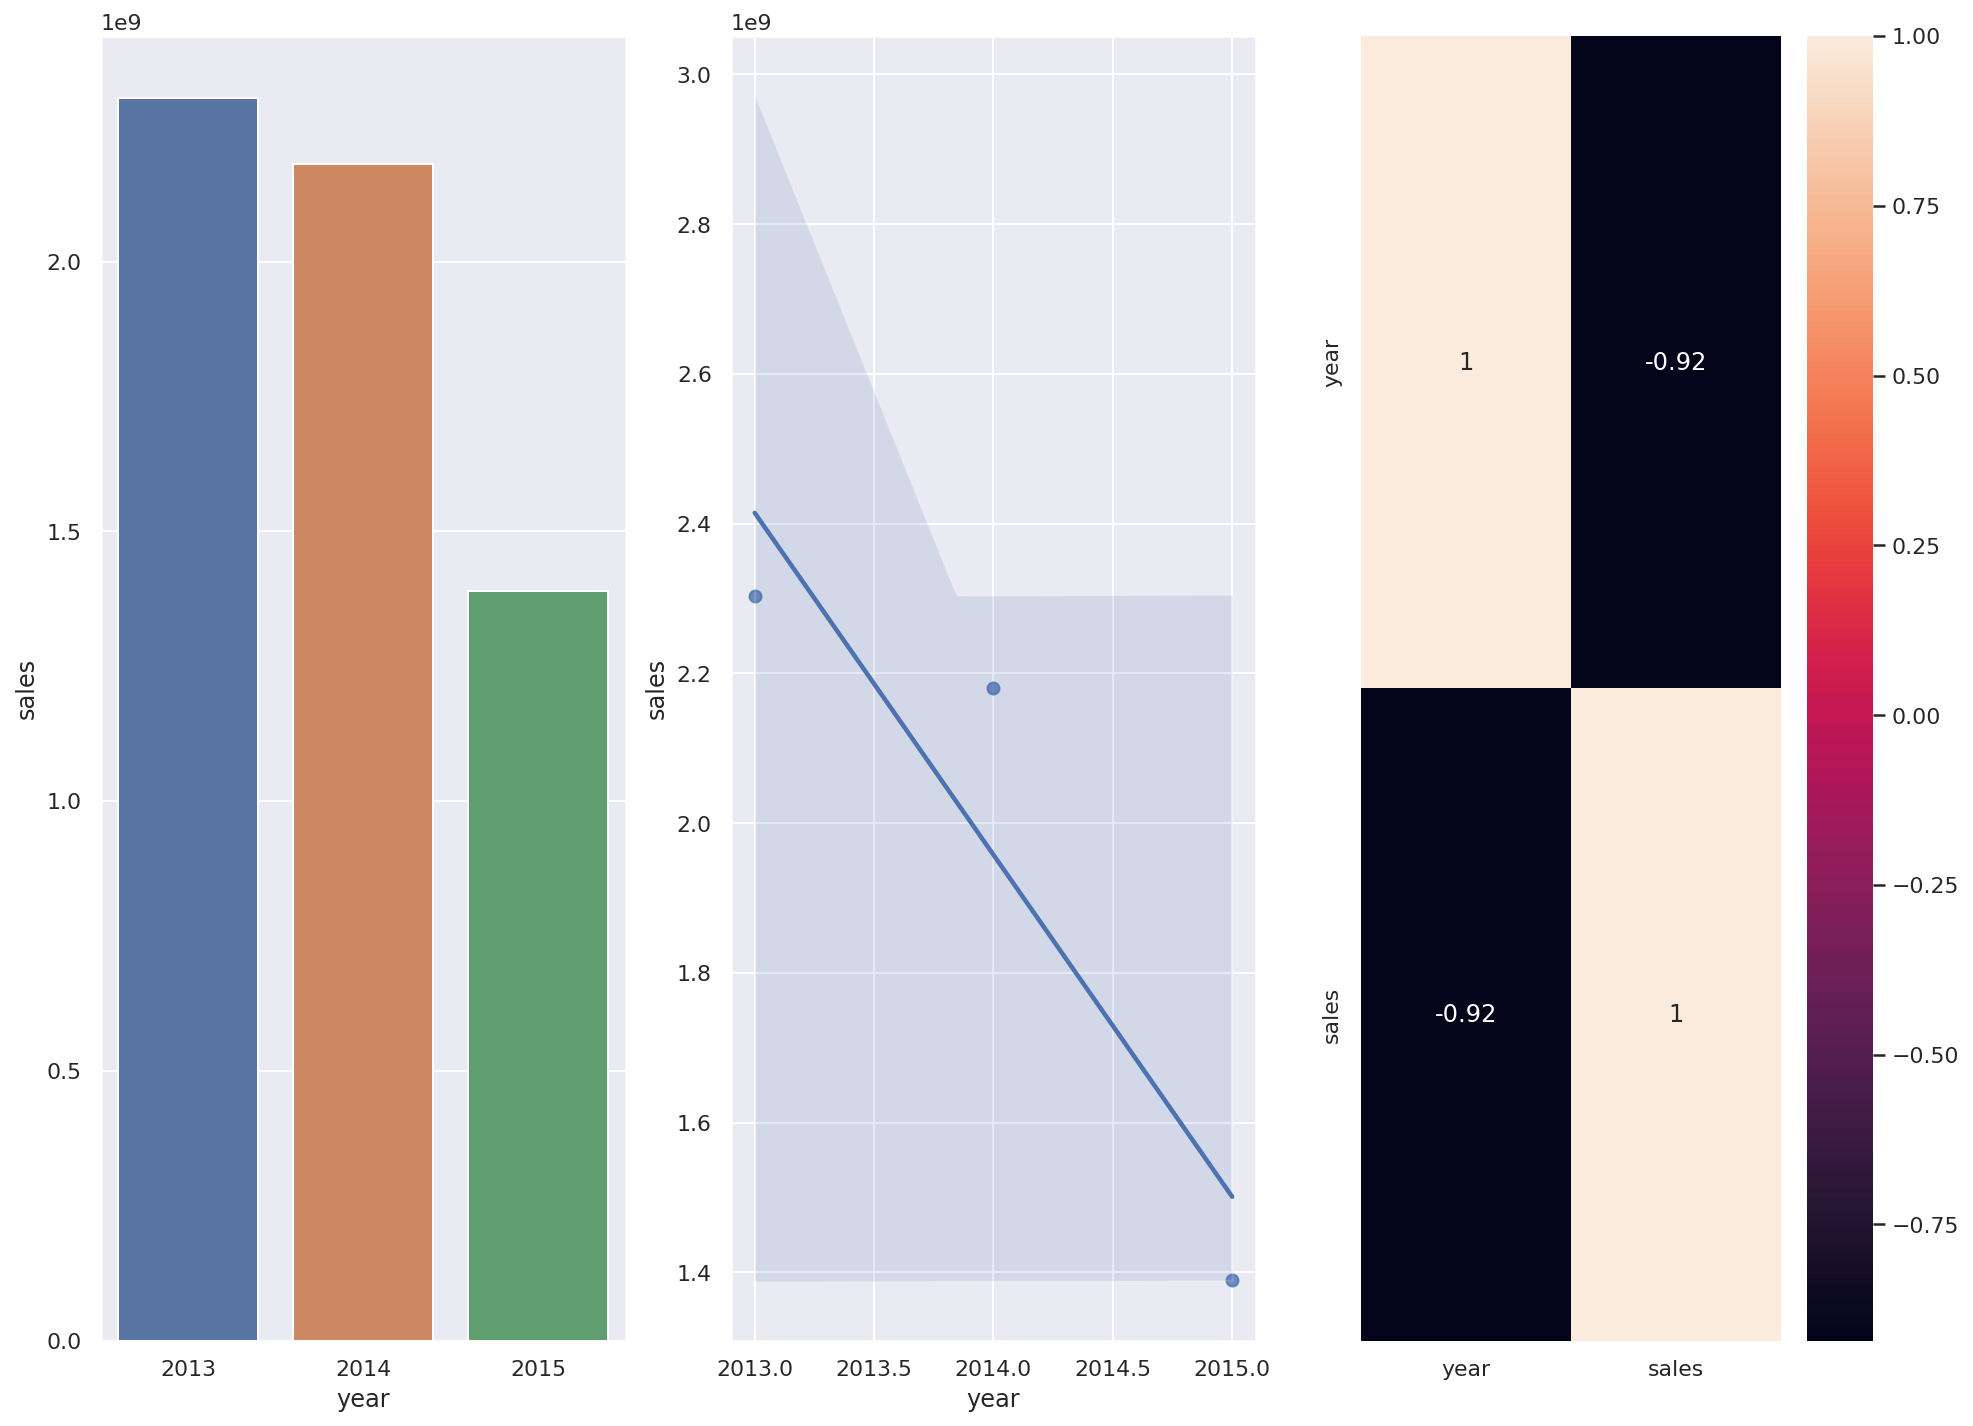

In [112]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

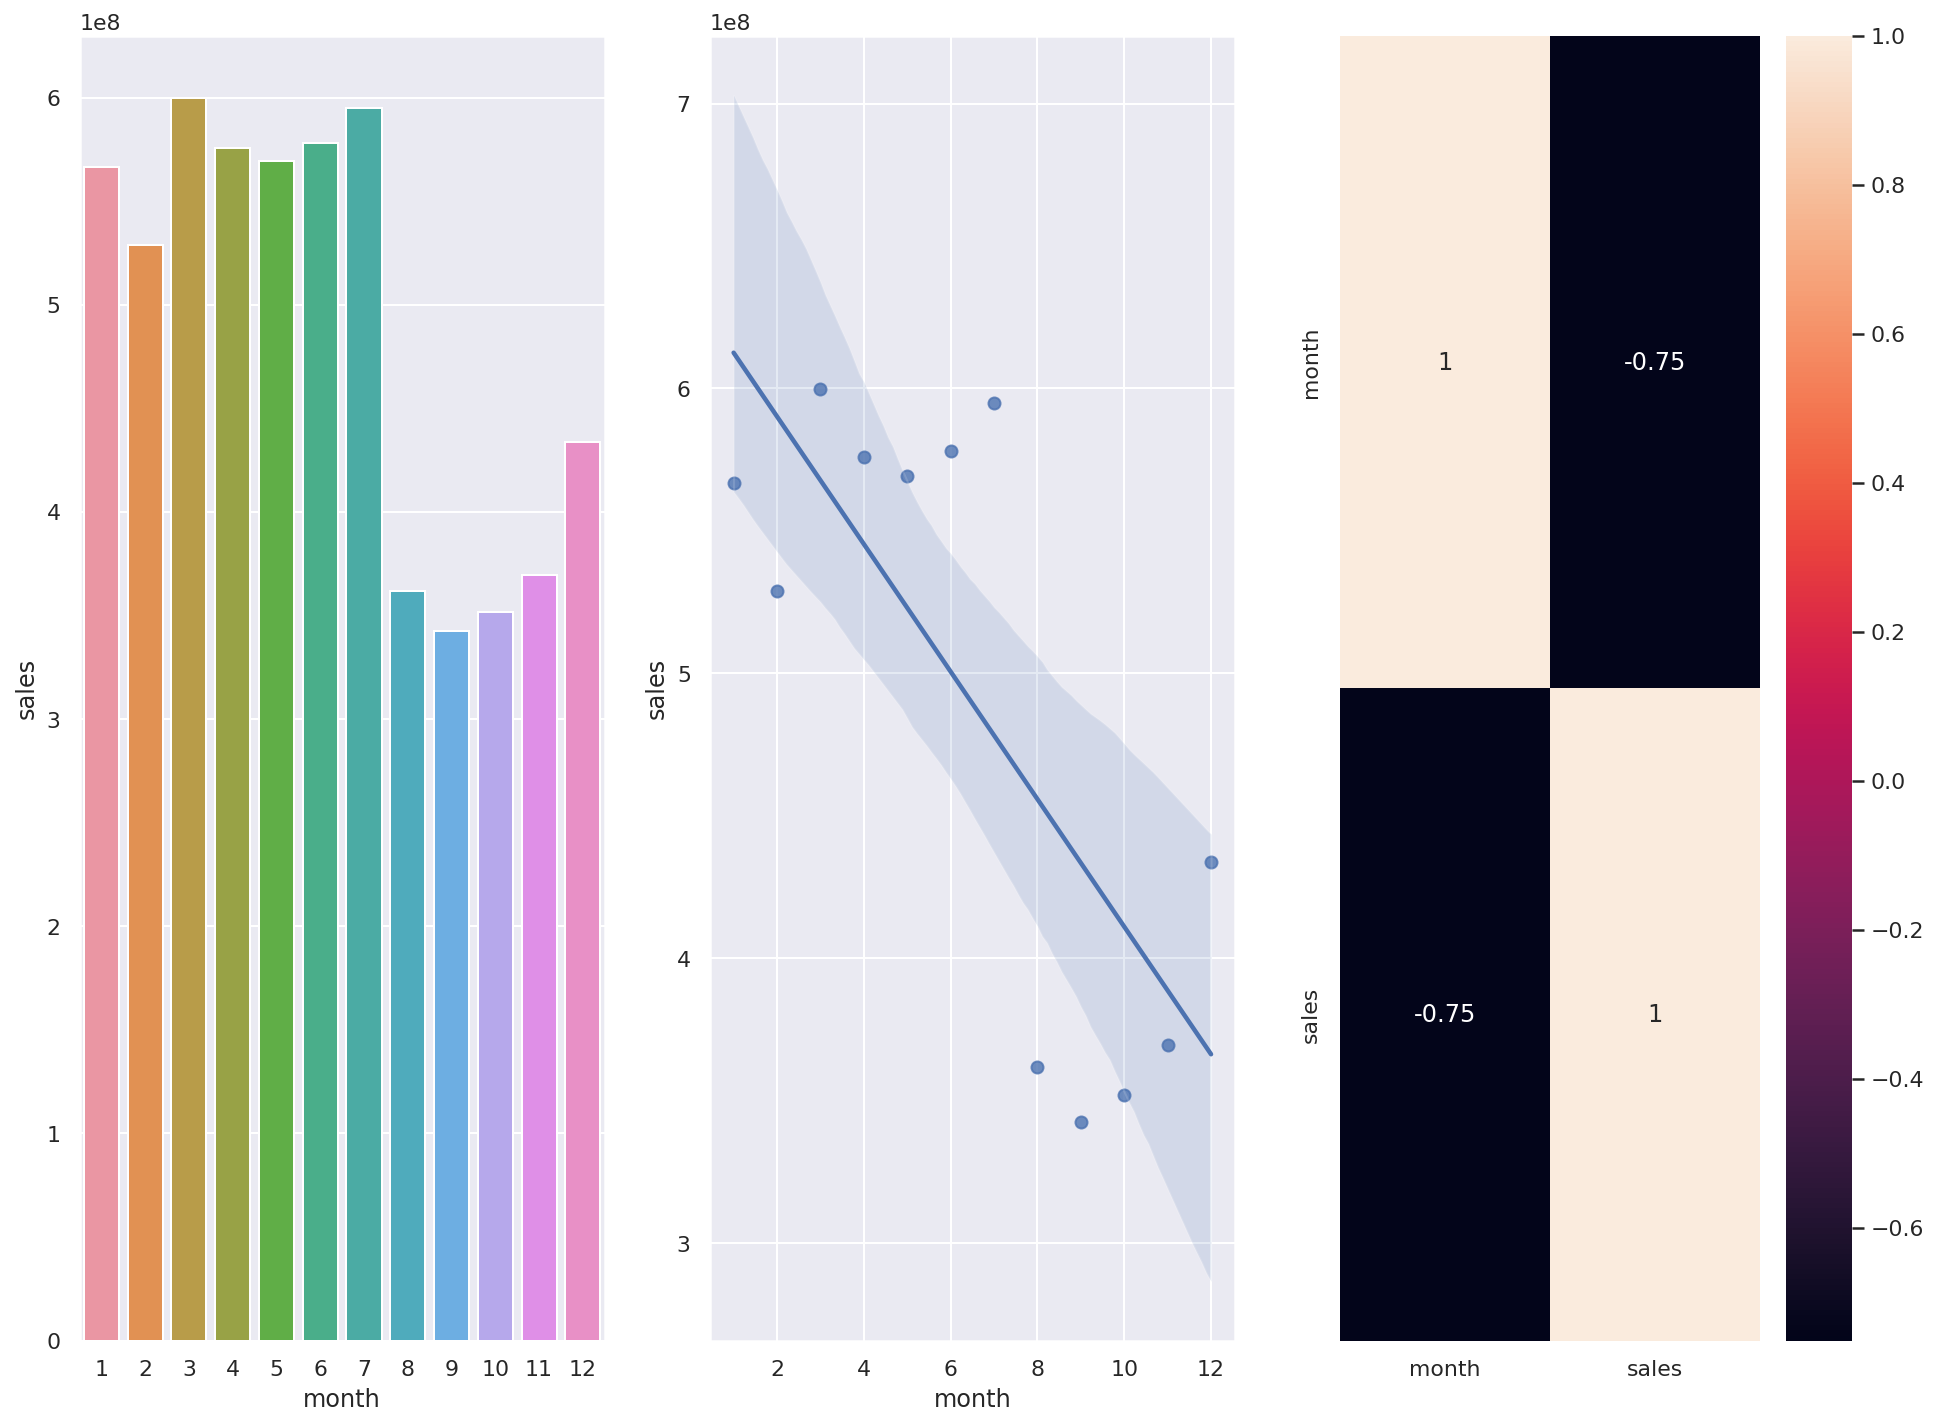

In [113]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

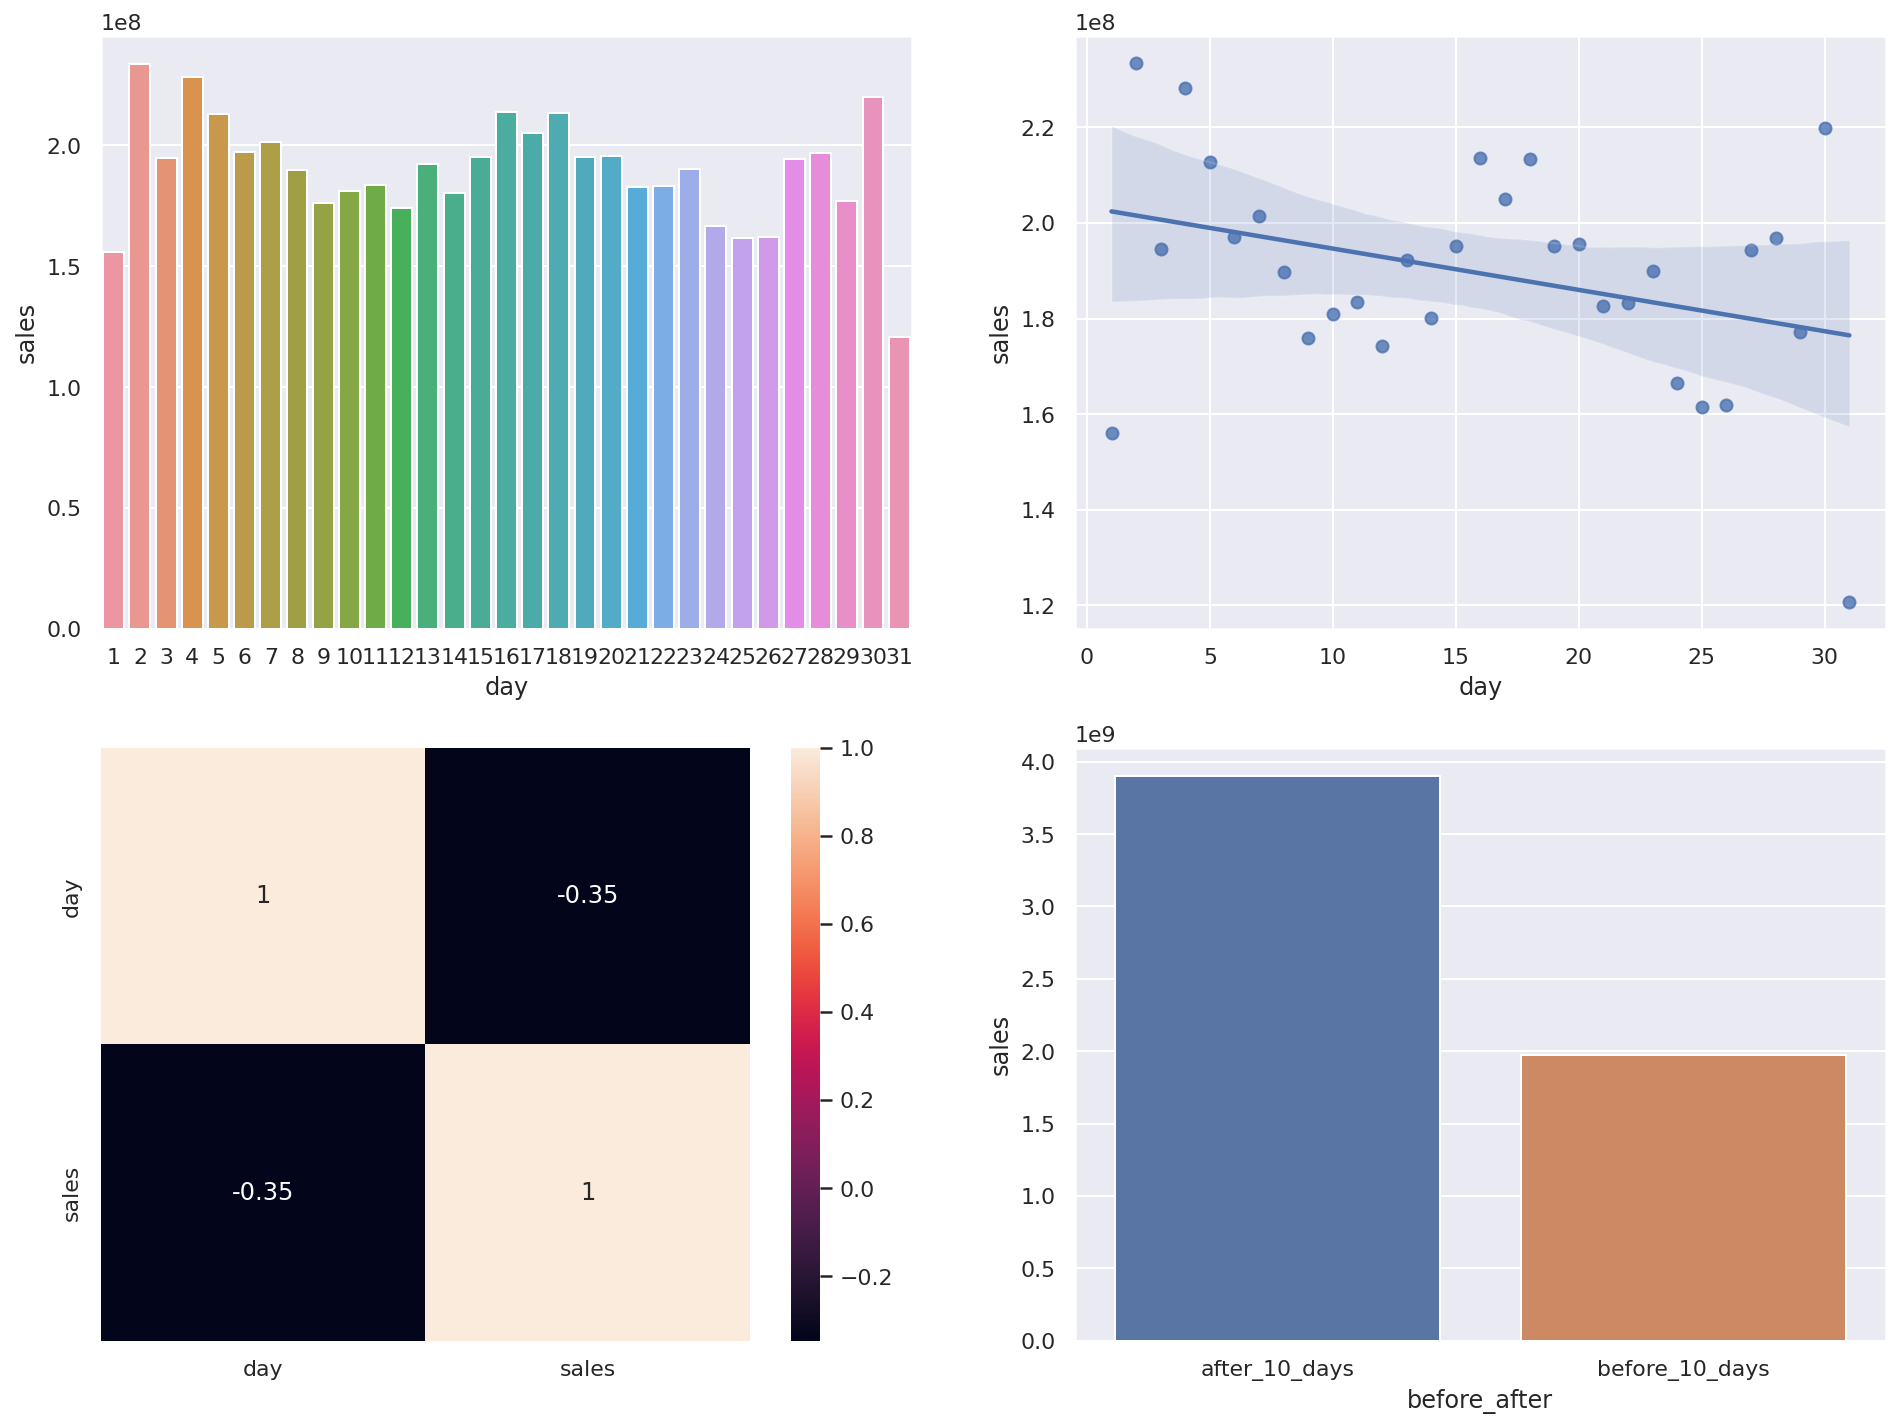

In [114]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### **H12.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

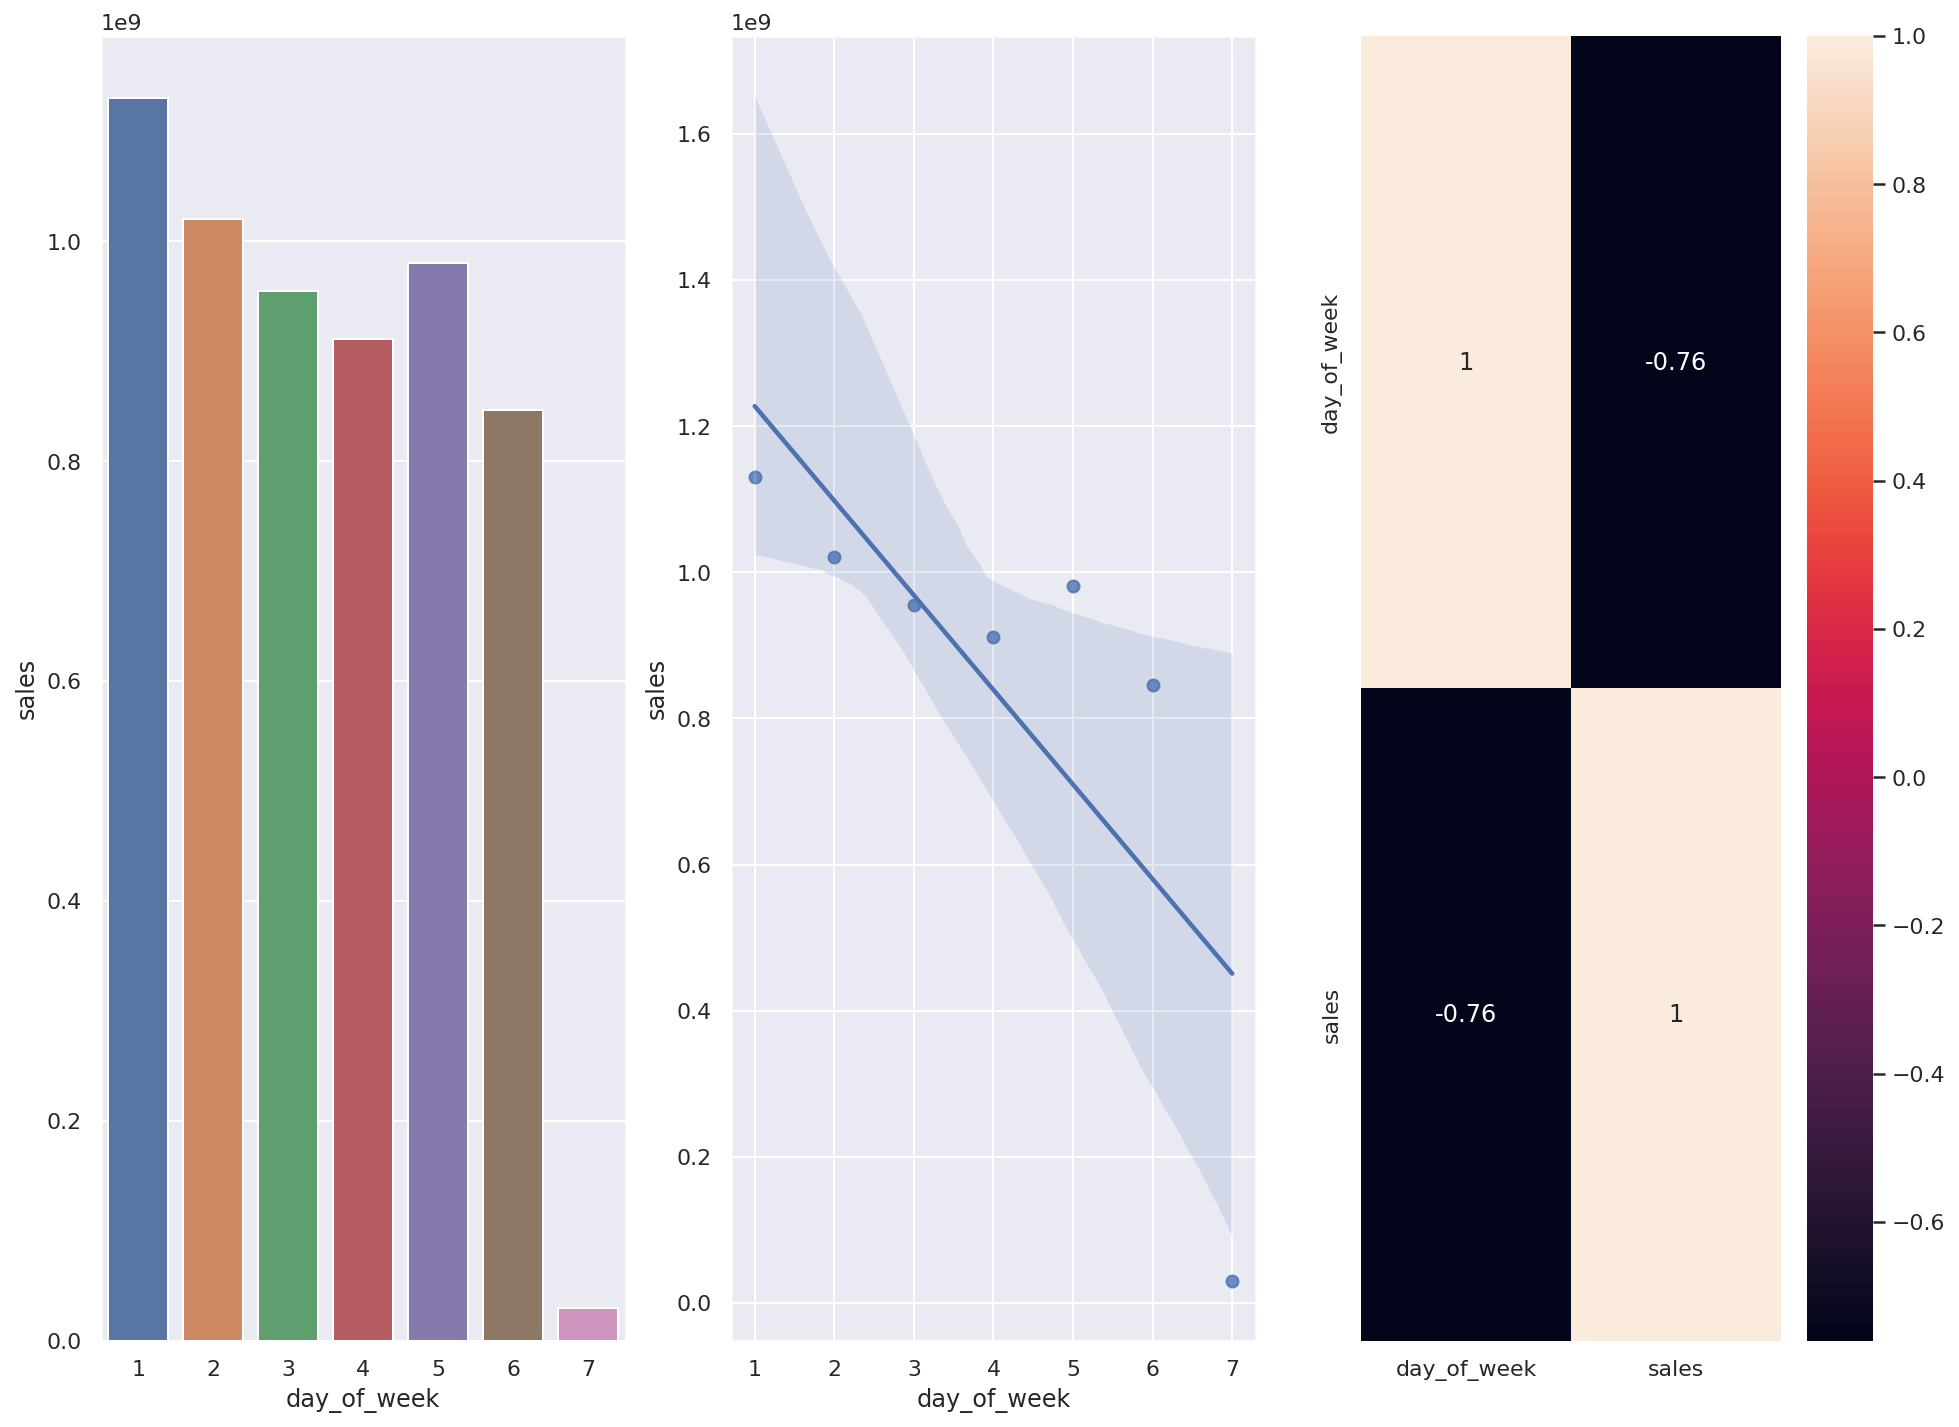

In [115]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.

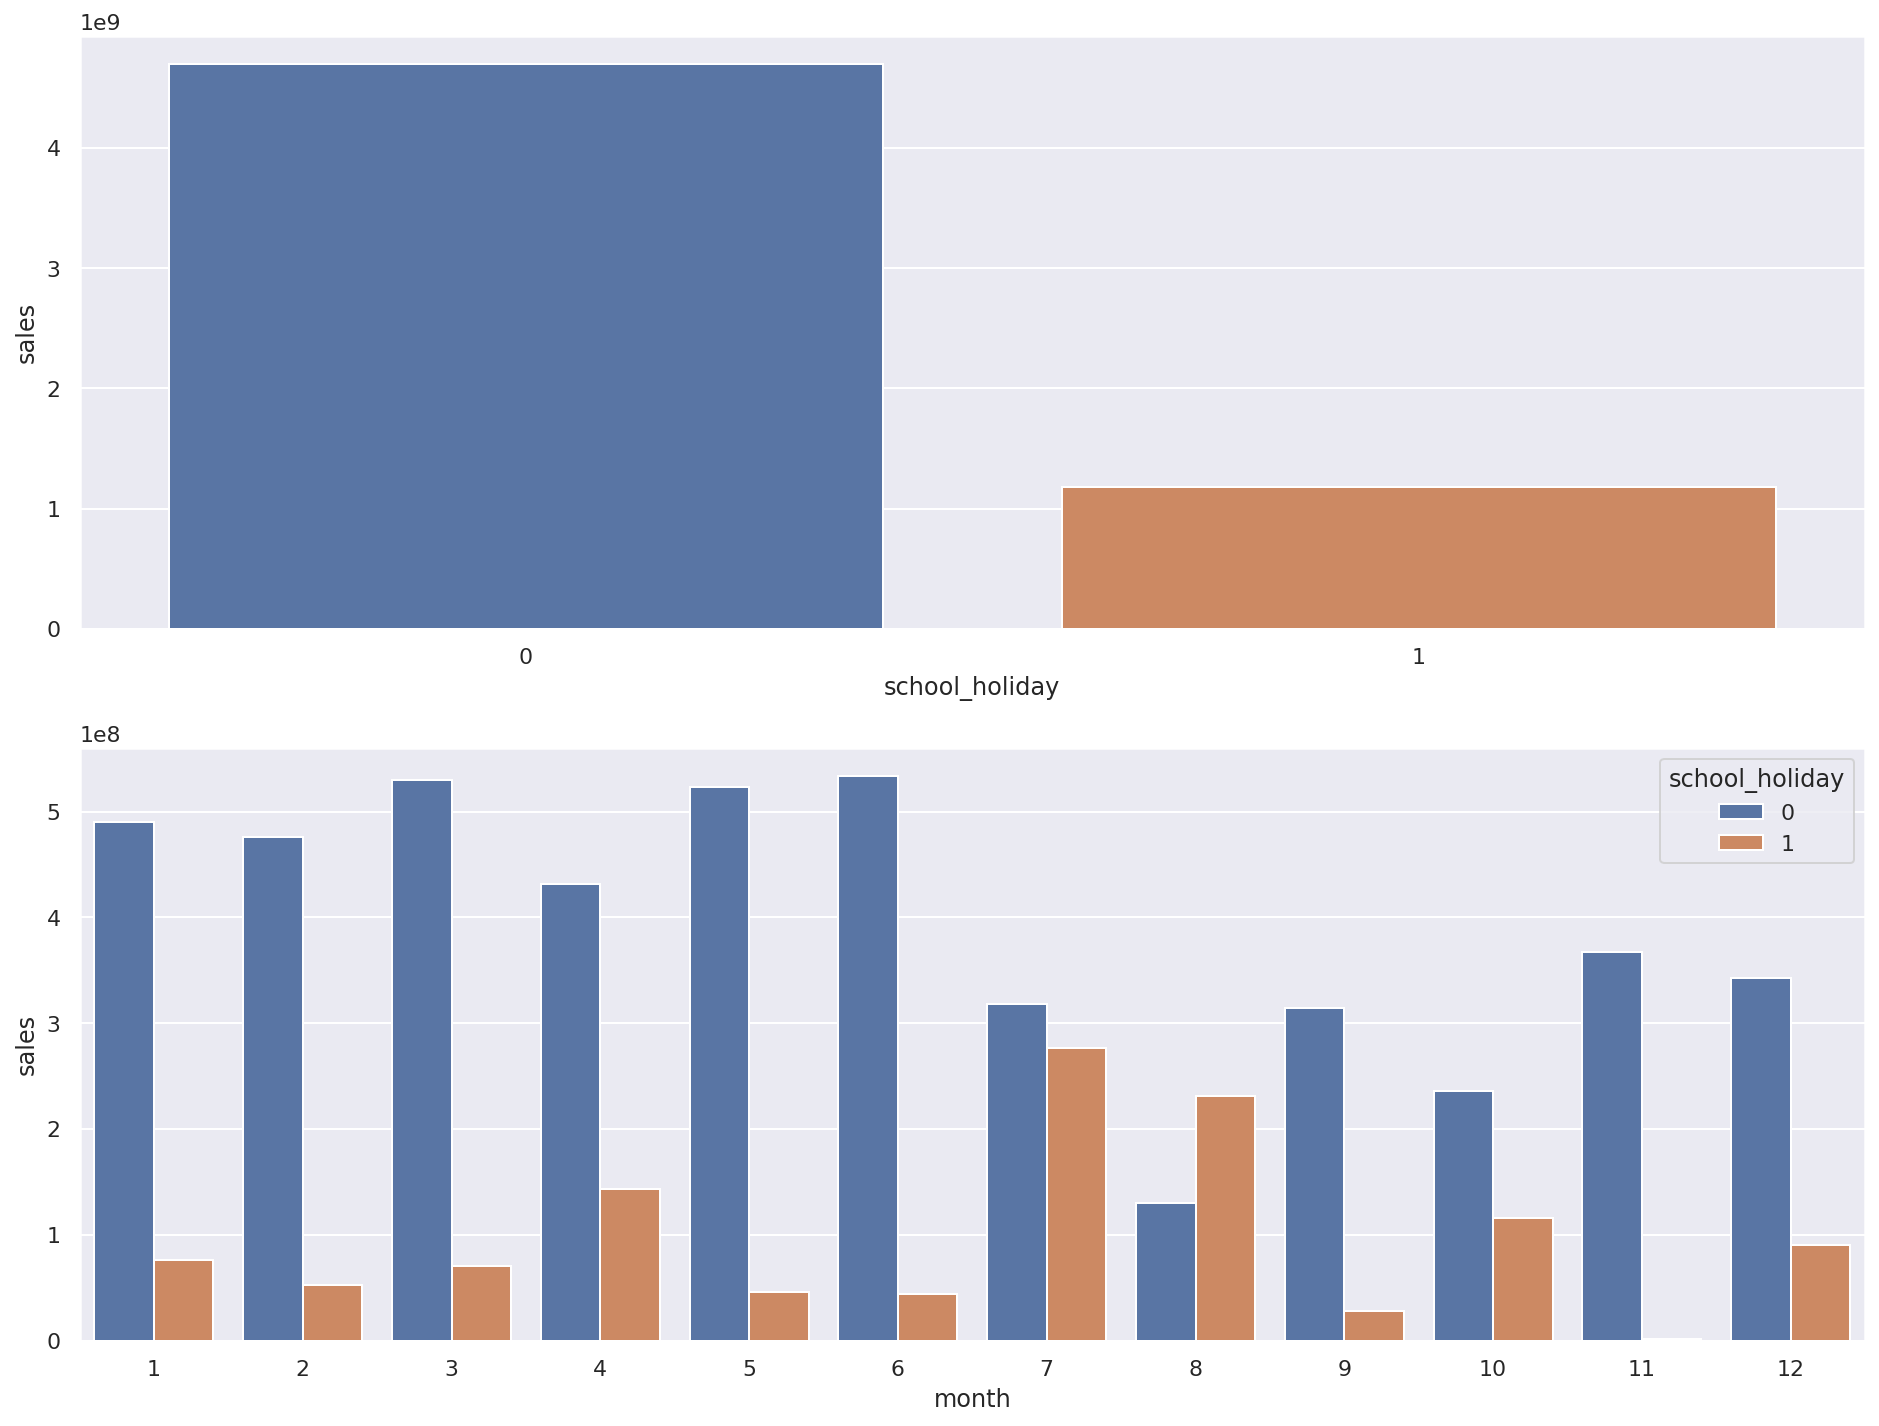

In [116]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### Resumo das Hipoteses

In [121]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## Analise Multivariada

### Numerical Attributes

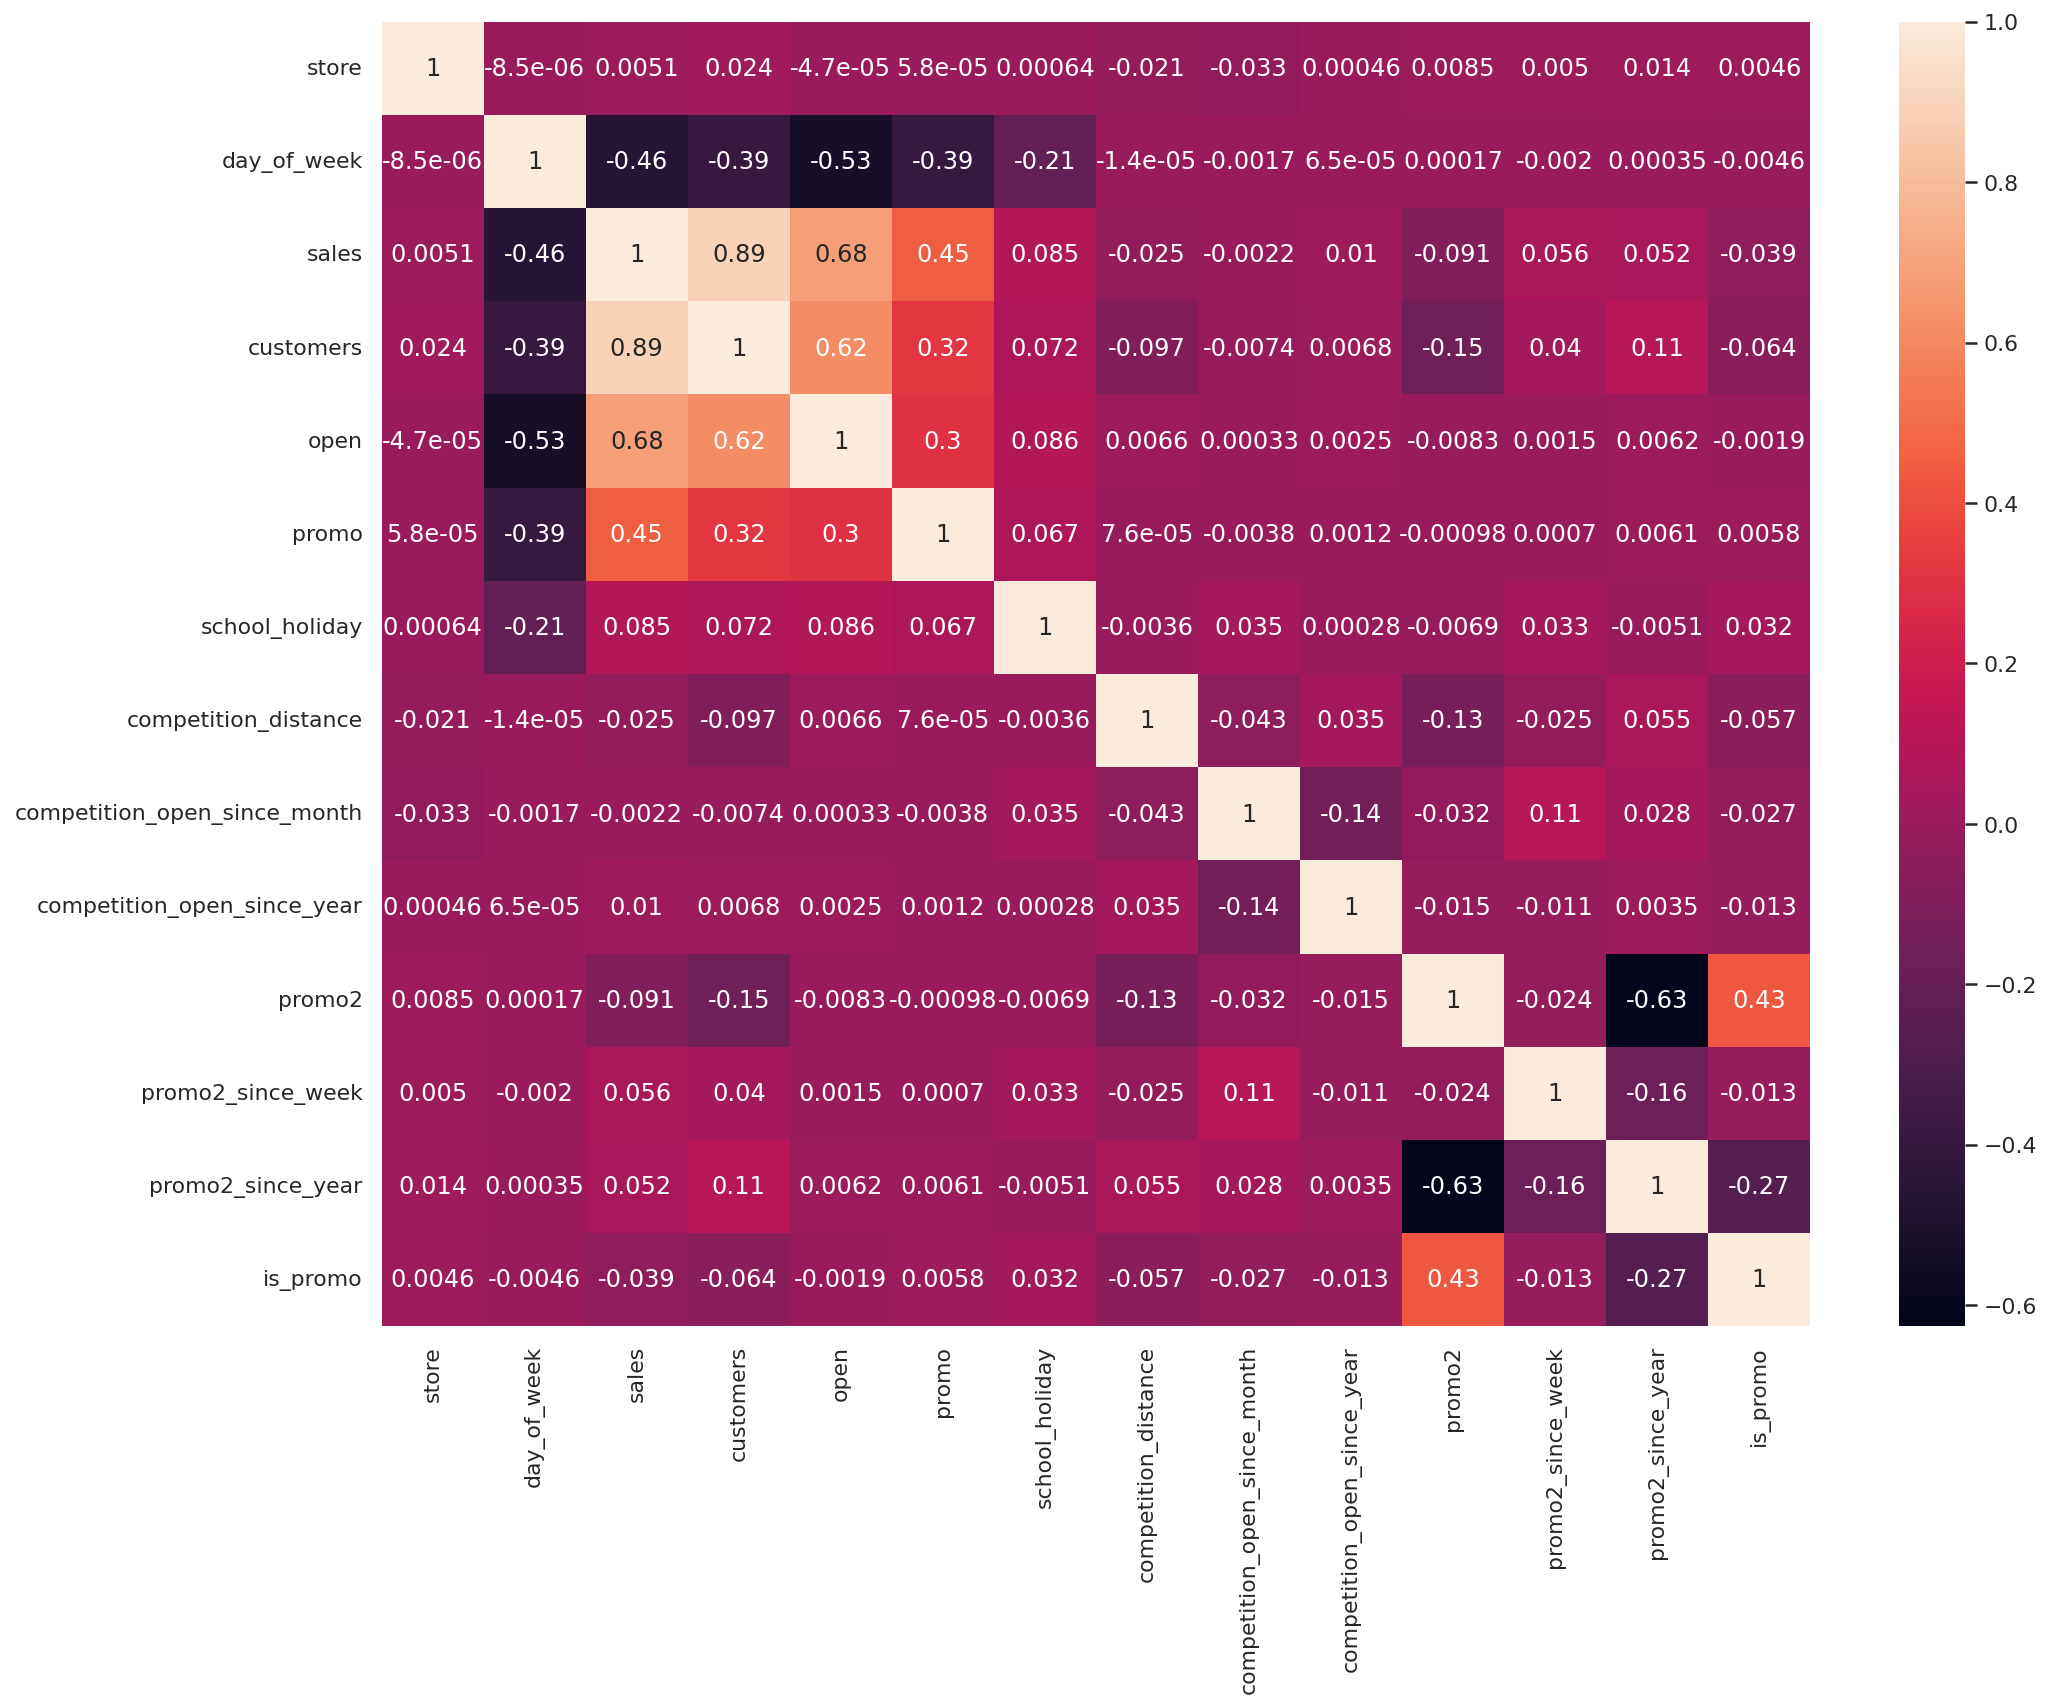

In [122]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### Categorical Attributes

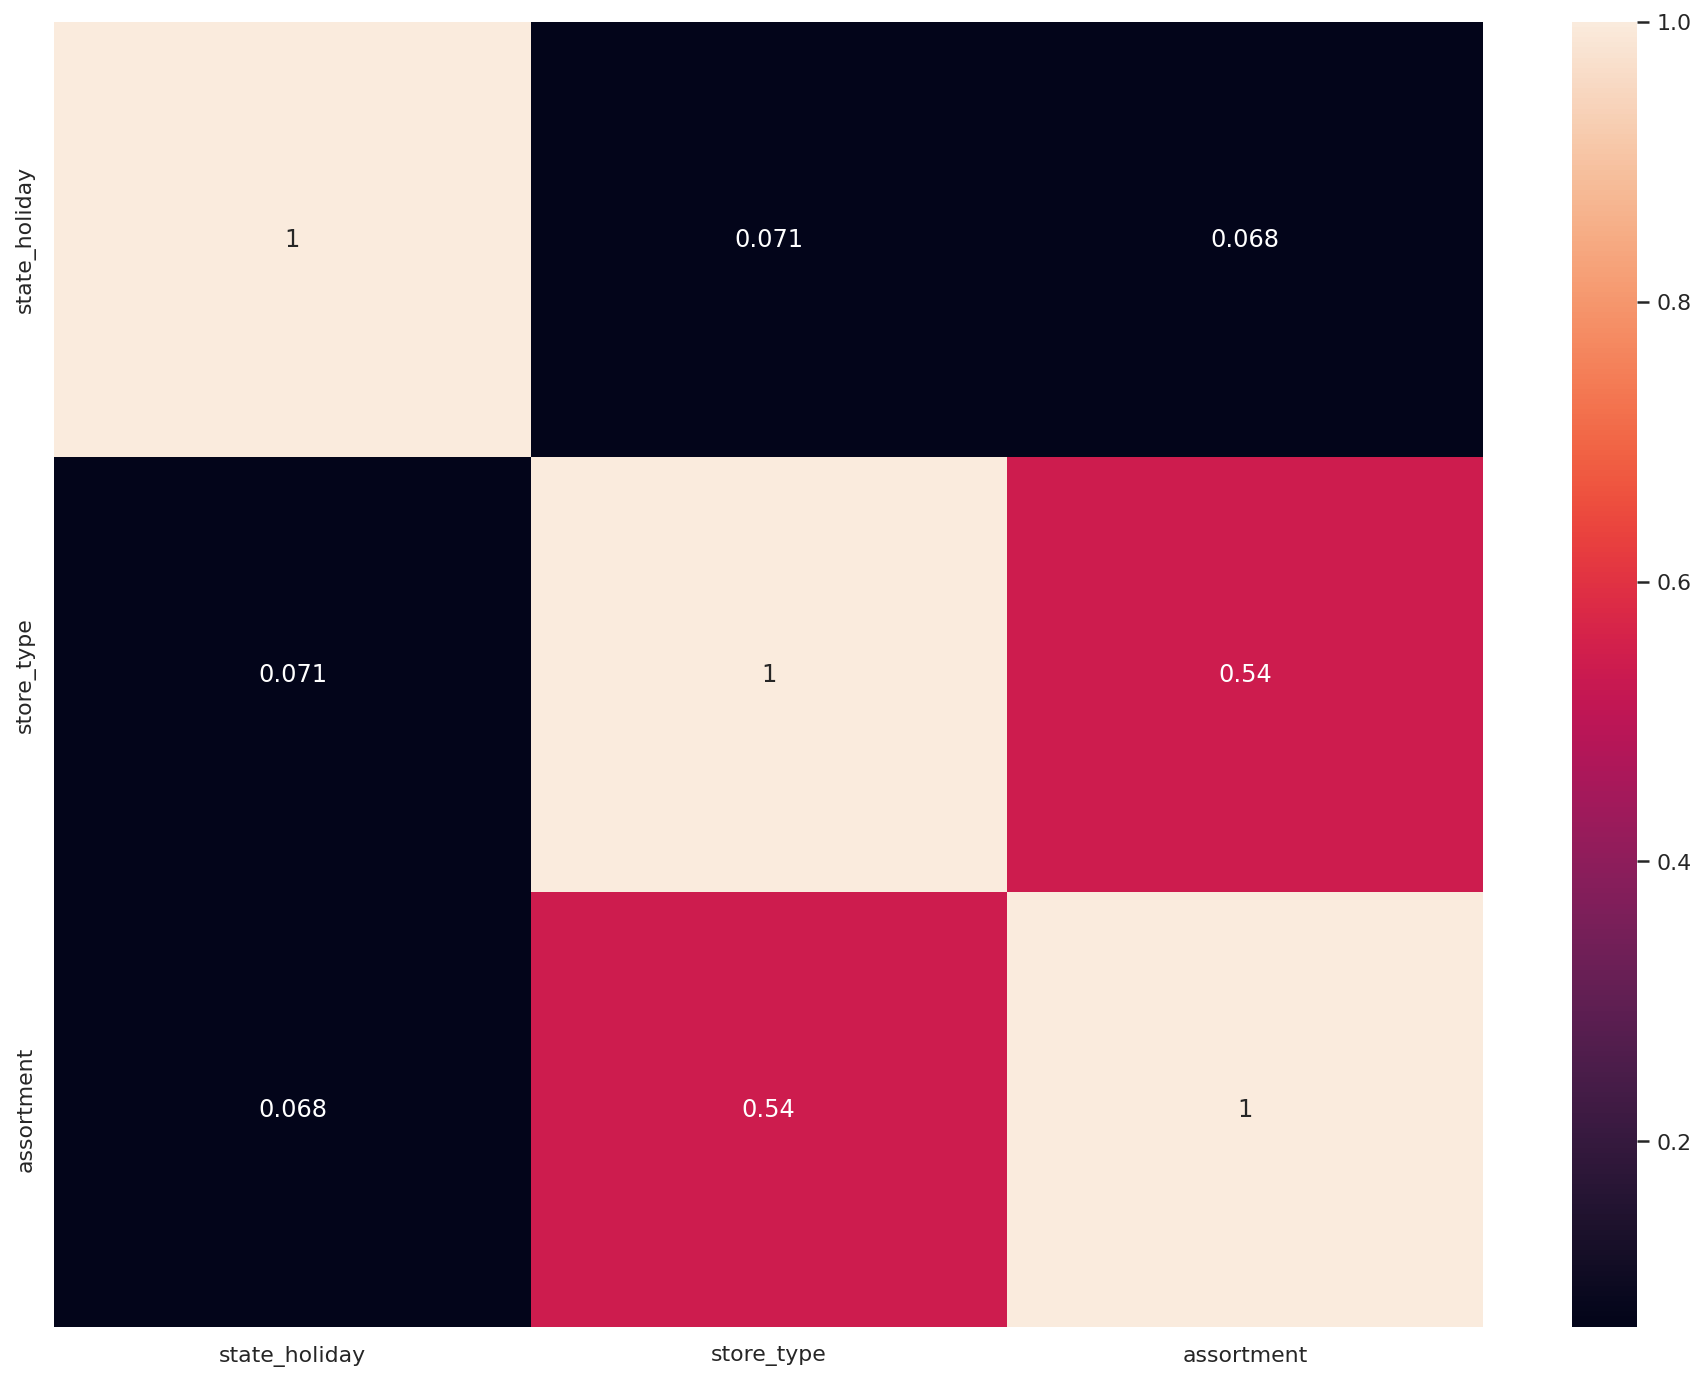

In [127]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

In [128]:
save_data( df4, 'df4.pkl' )

# DATA PREPARATION

In [132]:
df5 = load_data( 'df4.pkl' )

## Normalizacao

## Rescaling

In [133]:
rs = RobustScaler()
mms = MinMaxScaler()

In [134]:
# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
save_model( rs, 'competition_distance_scaler.pkl' )

In [135]:
# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
save_model( rs, 'competition_time_month_scaler.pkl' )

In [136]:
# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
save_model( rs, 'promo_time_week_scaler.pkl' )

In [137]:
# year
df5['year'] = mms.fit_transform( df5[['year']].values )
save_model( mms, 'year_scaler.pkl' )

## Transformacao

### Encoding

In [138]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

In [139]:
# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
save_model( le, 'store_type_scaler.pkl' )

In [140]:
# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### Response Variable Transformation

In [141]:
df5['sales'] = np.log1p( df5['sales'] )

### Nature Transformation

In [142]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

In [143]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

In [144]:
# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

In [145]:
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [146]:
save_data( df5, 'df5.pkl' )

# FEATURE SELECTION

In [194]:
df6 = df5.copy()

In [195]:
l0, c = df6.shape
print('df6 have {} Lines and {} Columns\n'.format( l0 , c ) )

df6 have 844338 Lines and 36 Columns



## Split dataframe into training and test dataset

In [196]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [197]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

l1, c = X_train.shape
print('X_train have {} Lines and {} Columns\n'.format( l1 , c ) )

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

l2, c = X_test.shape
print('X_test have {} Lines and {} Columns\n'.format( l2 , c ) )



X_train have 802942 Lines and 29 Columns

X_test have 41396 Lines and 29 Columns



In [198]:
# print min and max date values
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}\n'.format( X_train['date'].max() ) )

print( 'Test Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

print("\nSo, if df6 have {} lines, the sum of X_train and X_test is {} lines to ! ok ?".format(l0, l1+l2))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00

So, if df6 have 844338 lines, the sum of X_train and X_test is 844338 lines to ! ok ?


In [199]:
save_model( X_train, 'X_train.pkl' )
save_model( y_train, 'y_train.pkl' )
save_model( X_test, 'X_test.pkl' )
save_model( y_test, 'y_test.pkl' )

In [200]:
save_data( df6, 'df6.pkl' )

## Boruta as Feature Selector

In [201]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### Best Features from Boruta

In [202]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## Manual Feature Selection

In [203]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [204]:
save_model( cols_selected_boruta, 'cols_selected_boruta.pkl' )
save_model( cols_selected_boruta_full, 'cols_selected_boruta_full.pkl' )
save_model( feat_to_add, 'feat_to_add.pkl' )

# MACHINE LEARNING MODELLING

In [77]:
X_train = load_model( 'X_train.pkl' )
y_train = load_model( 'y_train.pkl' )
X_test = load_model( 'X_test.pkl' )
y_test = load_model( 'y_test.pkl' )

In [78]:
cols_selected_boruta = load_model( 'cols_selected_boruta.pkl' )
cols_selected_boruta_full = load_model( 'cols_selected_boruta_full.pkl' )
feat_to_add = load_model( 'feat_to_add.pkl' )

In [79]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## Average Model

In [22]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

Model Name        MAE   MAPE%       RMSE
0  Average Model 1,354.8004 45.5051 1,835.1355

## Linear Regression Model

In [23]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

Model Name        MAE   MAPE%       RMSE
0  Linear Regression 1,870.2725 29.3160 2,671.2176

### Linear Regression Model - Cross Validation

In [24]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

Model Name              MAE CV         MAPE CV             RMSE CV
0  Linear Regression  2082.46 +/- 295.78  30.26 +/- 1.66  2950.11 +/- 468.88

## Linear Regression Regularized Model - Lasso

In [25]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

Model Name        MAE   MAPE%       RMSE
0  Linear Regression - Lasso 1,893.2314 28.9282 2,744.4521

### Lasso - Cross Validation

In [26]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

Model Name              MAE CV        MAPE CV             RMSE CV
0      Lasso  2116.65 +/- 341.58  29.2 +/- 1.18  3056.56 +/- 504.44

## Random Forest Regressor

In [27]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

Model Name      MAE  MAPE%       RMSE
0  Random Forest Regressor 679.0812 9.9879 1,010.1021

### Random Forest Regressor - Cross Validation

In [28]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=False )
rf_result_cv

Model Name            MAE CV         MAPE CV             RMSE CV
0  Random Forest Regressor  837.7 +/- 219.23  11.61 +/- 2.32  1256.59 +/- 320.26

## XGBoost Regressor

In [29]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.03, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.7 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

Model Name        MAE   MAPE%       RMSE
0  XGBoost Regressor 2,632.1274 32.9034 3,440.8114

### XGBoost Regressor - Cross Validation

In [30]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name              MAE CV         MAPE CV            RMSE CV
0  XGBoost Regressor  2889.54 +/- 343.25  34.54 +/- 1.39  3714.69 +/- 456.1

## Compare Model's Performance

### Single Performance

In [31]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

Model Name        MAE   MAPE%       RMSE
0    Random Forest Regressor   679.0812  9.9879 1,010.1021
0              Average Model 1,354.8004 45.5051 1,835.1355
0          Linear Regression 1,870.2725 29.3160 2,671.2176
0  Linear Regression - Lasso 1,893.2314 28.9282 2,744.4521
0          XGBoost Regressor 2,632.1274 32.9034 3,440.8114

### Real Performance - Cross Validation

In [32]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

Model Name              MAE CV         MAPE CV             RMSE CV
0        Linear Regression  2082.46 +/- 295.78  30.26 +/- 1.66  2950.11 +/- 468.88
0                    Lasso  2116.65 +/- 341.58   29.2 +/- 1.18  3056.56 +/- 504.44
0  Random Forest Regressor    837.7 +/- 219.23  11.61 +/- 2.32  1256.59 +/- 320.26
0        XGBoost Regressor  2889.54 +/- 343.25  34.54 +/- 1.39   3714.69 +/- 456.1

# HYPERPARAMETER FINE TUNING

## Random Search

In [33]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [34]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

In [35]:
#final_result

## Final Model

In [80]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [81]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] )

In [82]:
model_xgb_tuned.fit( x_train, y_train )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             eta=0.03, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0299999993,
             max_delta_step=0, max_depth=5, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [83]:
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

In [84]:
# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

Model Name      MAE   MAPE%       RMSE
0  XGBoost Regressor 764.9756 11.4861 1,100.7251

In [85]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.01759492443152097

In [86]:
save_model( model_xgb_tuned, 'model_xgb_tuned.pkl' )
save_model( xgb_result_tuned, 'xgb_result_tuned.pkl' )
save_model( yhat_xgb_tuned, 'yhat_xgb_tuned.pkl' )

# TRADUCAO E INTERPRETACAO DO ERRO

In [87]:
model_xgb_tuned = load_model( 'model_xgb_tuned.pkl' )
xgb_result_tuned = load_model( 'xgb_result_tuned.pkl' )
yhat_xgb_tuned = load_model( 'yhat_xgb_tuned.pkl' )
cols_selected_boruta_full = load_model( 'cols_selected_boruta_full.pkl')

In [88]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## Business Performance

In [89]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [90]:
df92.sort_values( 'MAPE', ascending=False ).head()

store  predictions  worst_scenario  best_scenario        MAE    MAPE
291    292 108,359.7891    104,977.6086   111,741.9695 3,382.1804 60.2768
908    909 220,300.0781    212,395.1411   228,205.0152 7,904.9371 51.8675
875    876 194,060.8125    189,924.5347   198,197.0903 4,136.2778 33.7730
169    170 201,541.6875    200,194.4216   202,888.9534 1,347.2659 33.2923
748    749 206,800.9531    205,789.1920   207,812.7142 1,011.7611 28.3049

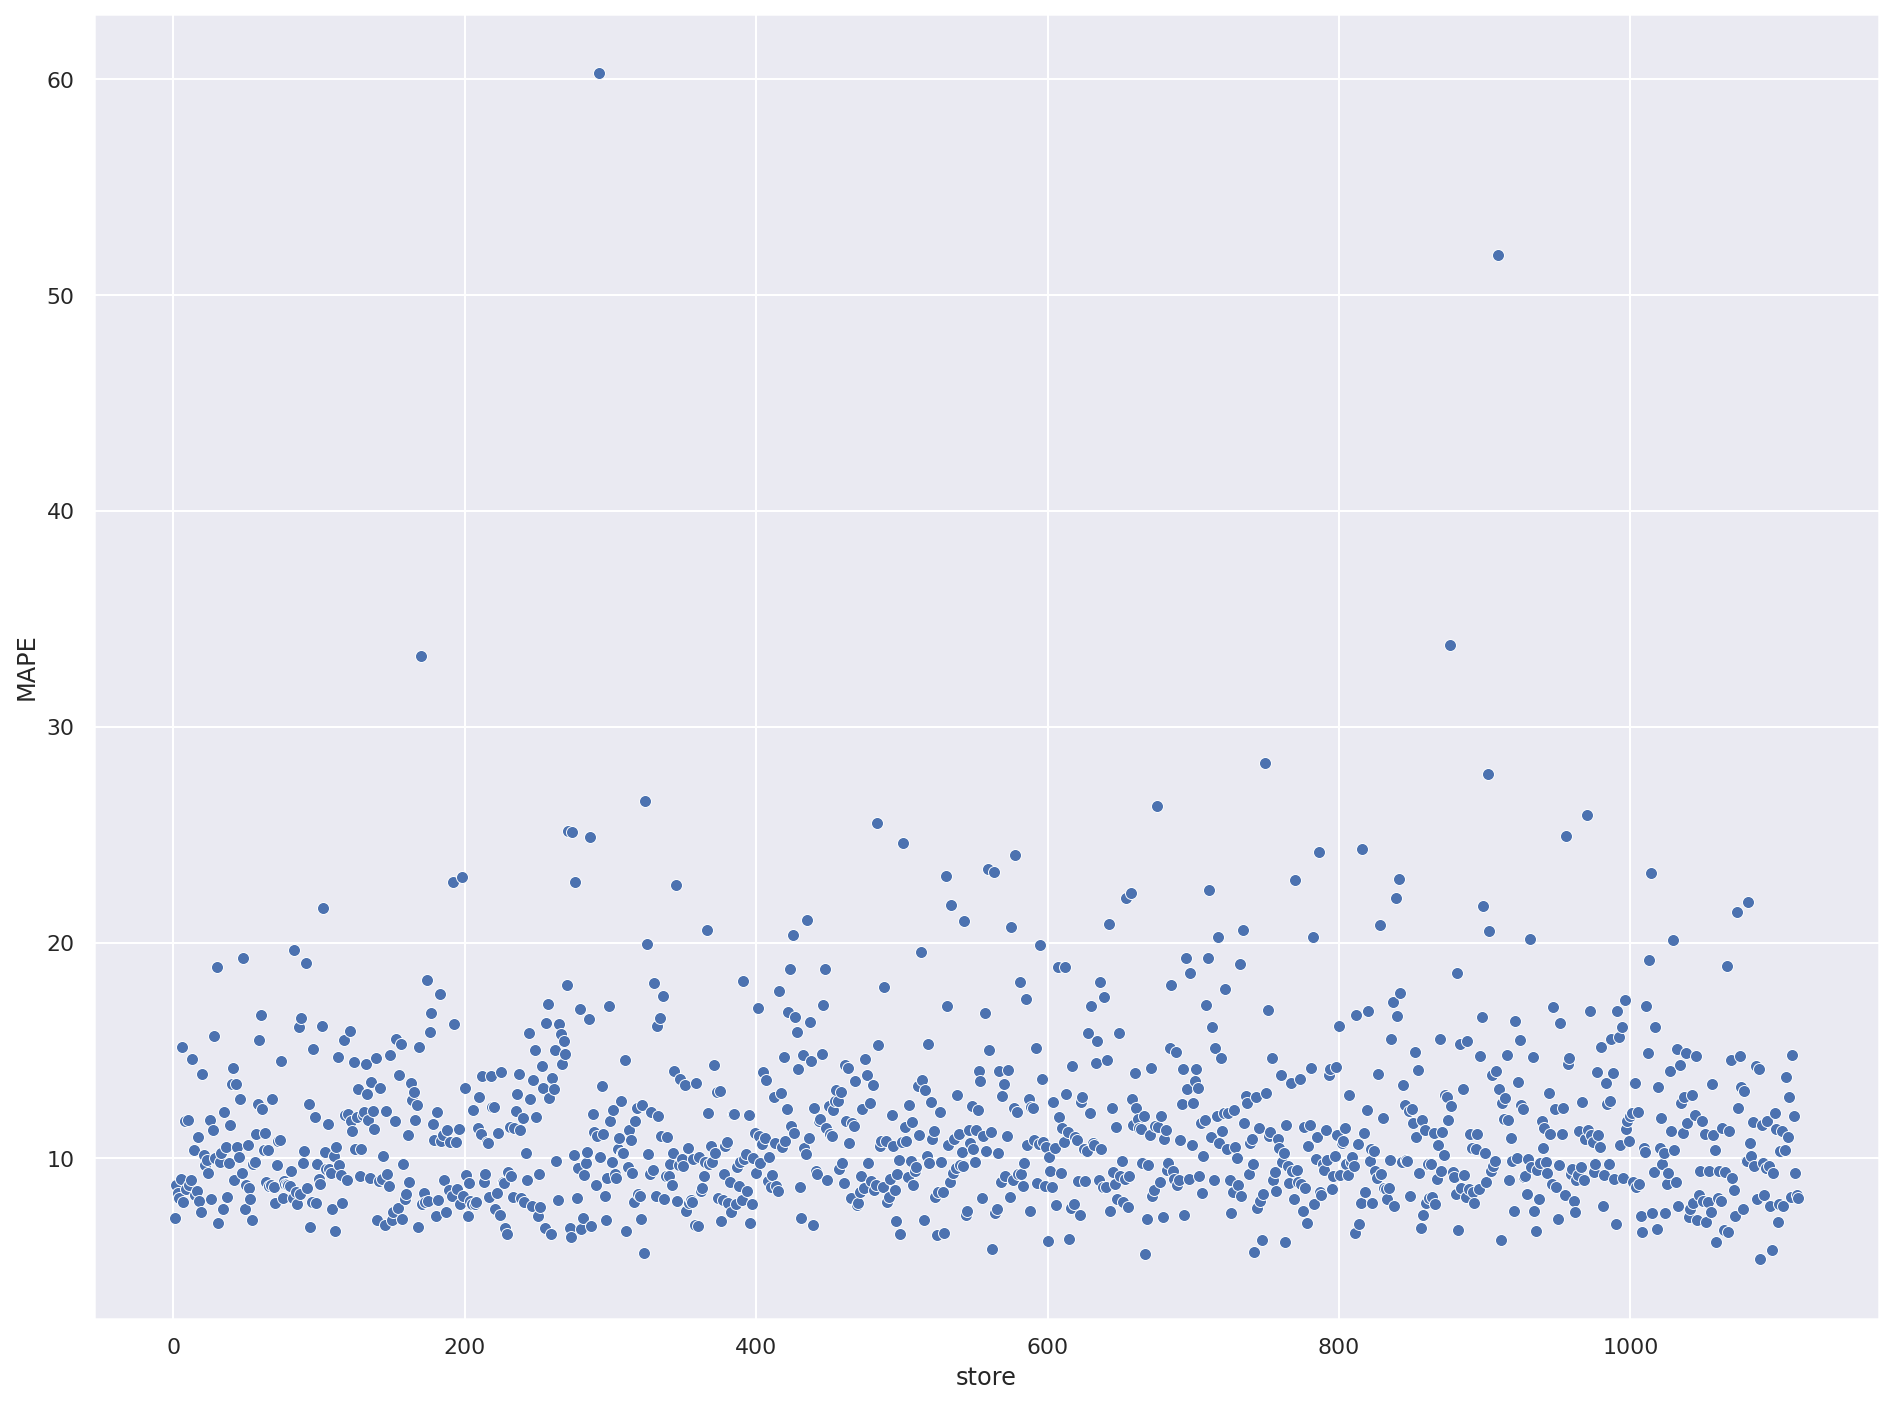

In [91]:
sns.scatterplot( x='store', y='MAPE', data=df92 );

## Total Performance

In [92]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

Scenario            Values
0     predictions  R$286,435,616.00
1  worst_scenario  R$285,579,535.55
2   best_scenario  R$287,291,675.73

## Machine Learning Performance

In [93]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

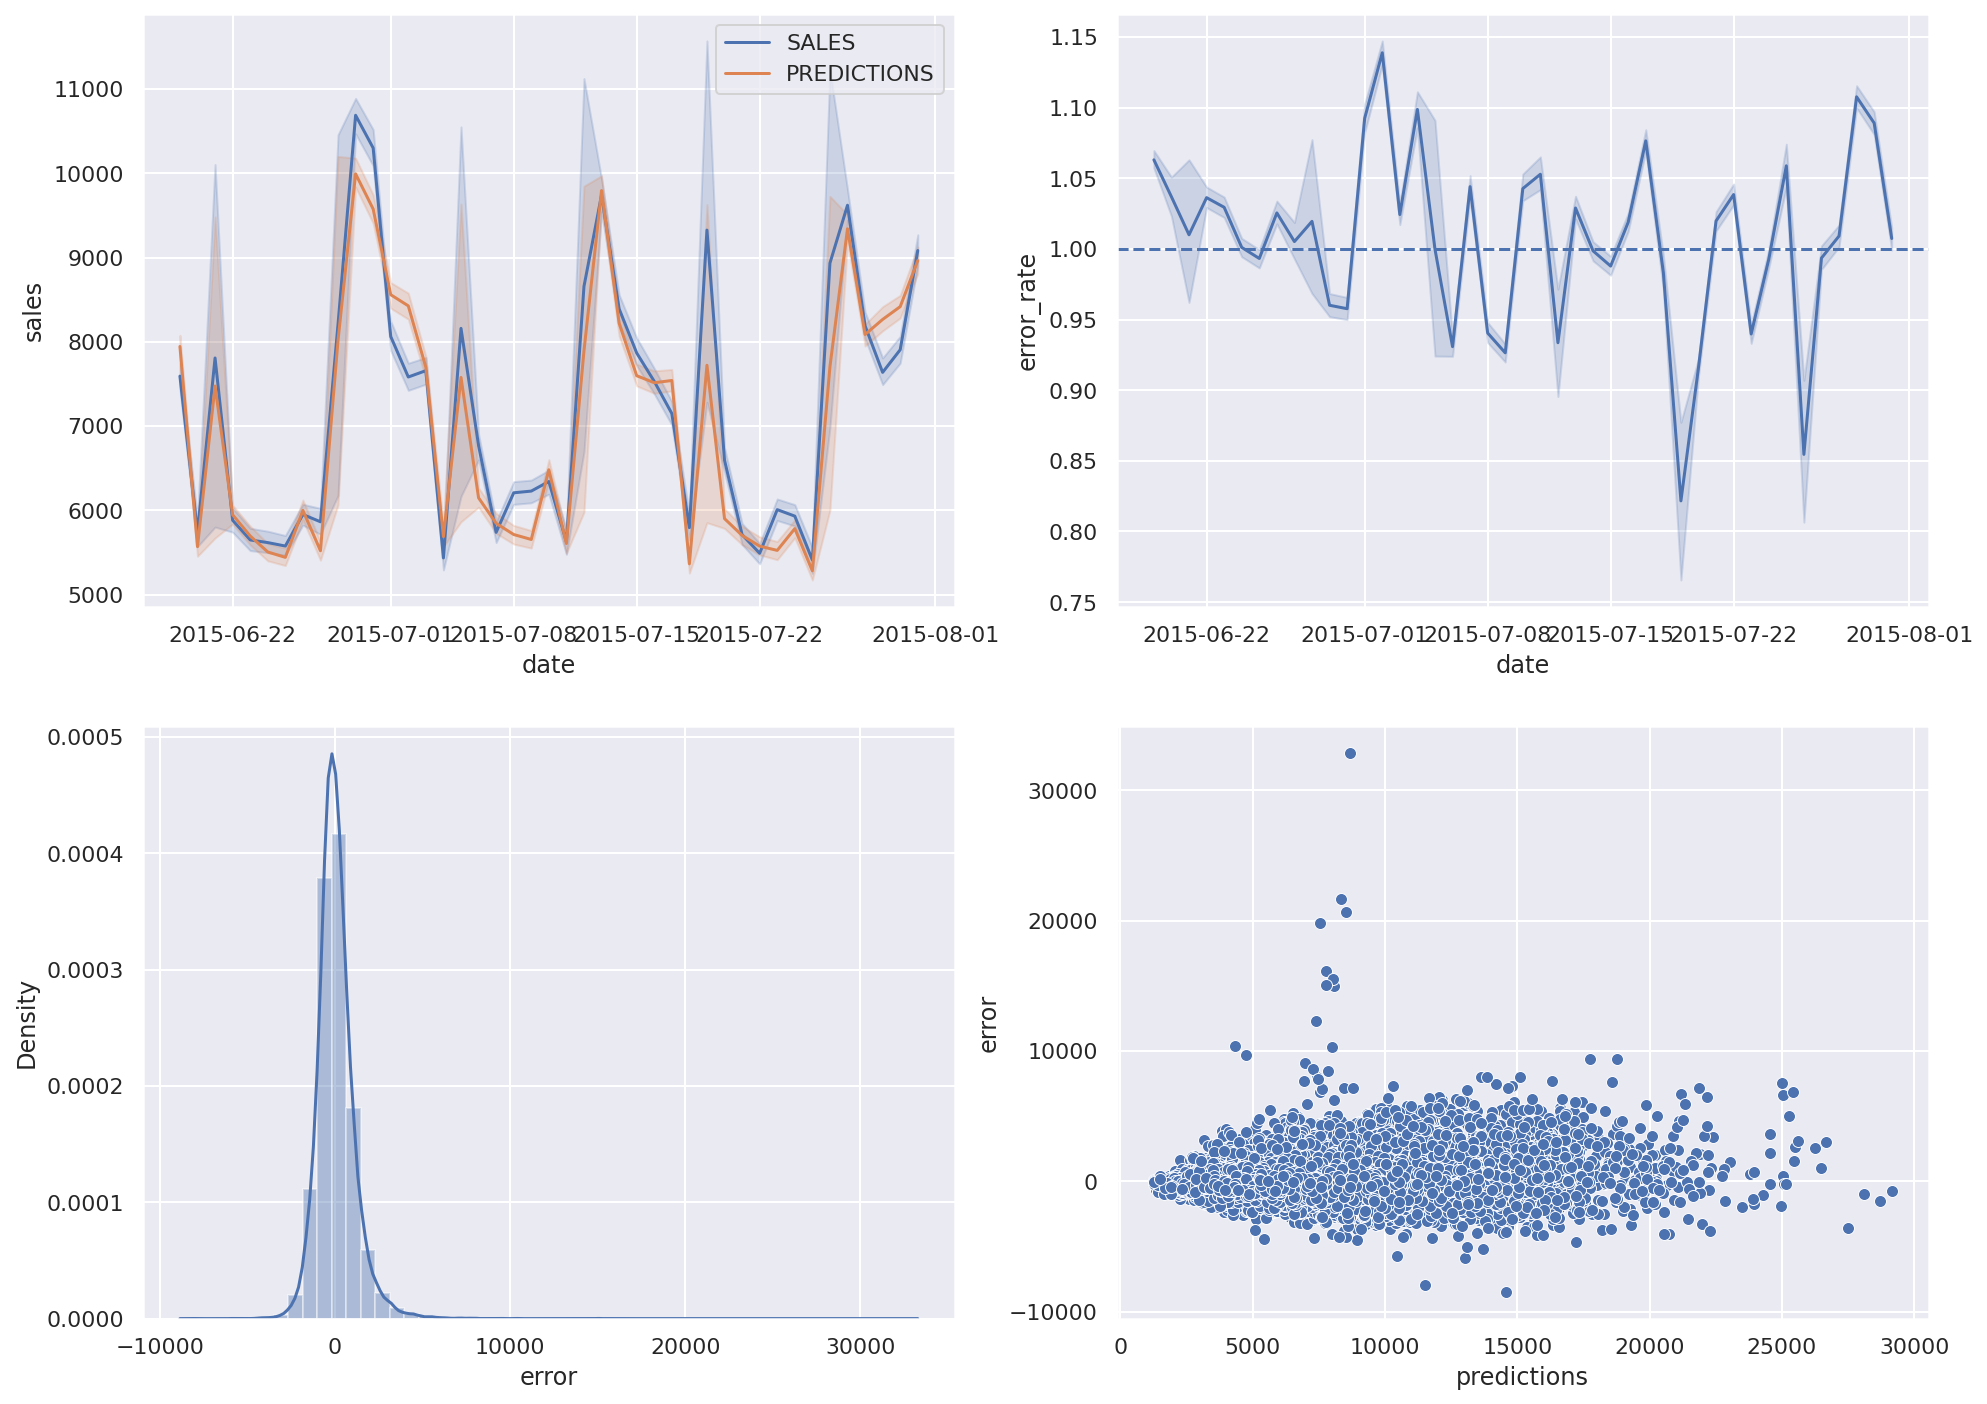

In [94]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] );

# DEPLOY MODEL TO PRODUCTION

In [95]:
save_model( model_xgb_tuned, 'rossmann_model.pkl' )

## Rossmann Class

In [53]:
import pickle
import pandas as pd
import numpy as np
import math
import datetime
import inflection

class Rossmann_c06( object ):
    def __init__( self ):
        self.home_path='/home/rodrigo/Projetos/Comunidade_DS/data_science_producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'models/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'models/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'models/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'models/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'models/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        #rename
        df1.columns = cols_new
    
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 100000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## API Handler

In [52]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.rossmann import Rossmann_c06

# loading model
model = pickle.load( open( '/home/rodrigo/Projetos/Comunidade_DS/data_science_producao/models/rossmann_model.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann_c06()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## API Tester

In [96]:
# loading test dataset
import json
df10 = pd.read_csv( '/home/rodrigo/Projetos/Comunidade_DS/data_science_producao/data/raw/test.csv', low_memory=False)
df_store_raw = pd.read_csv('/home/rodrigo/Projetos/Comunidade_DS/data_science_producao/data/raw/store.csv', low_memory=False)

In [97]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

In [98]:
# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22, 50, 75, 97] )]

In [99]:
# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [100]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [101]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
# url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 

In [102]:
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [103]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [104]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$283,041.80 in the next 6 weeks
Store Number 22 will sell R$209,333.94 in the next 6 weeks
Store Number 23 will sell R$248,503.56 in the next 6 weeks
Store Number 50 will sell R$198,073.54 in the next 6 weeks
Store Number 75 will sell R$283,260.97 in the next 6 weeks
